# 配置环境

## 加载路径

In [ ]:
import os
os.chdir("/content/drive/Othercomputers/我的笔记本电脑/A-GAN/StyleIntervention")

## pytorch版本

In [ ]:
import torch
torch.__version__

'1.7.1'

### 使用网盘whl文件配置环境

In [ ]:
# 下载whl文件到本地
!pip download torch==1.7.1

In [ ]:
# 移动whl文件到云空间
!cp /content/torch-1.7.1-cp37-cp37m-manylinux1_x86_64.whl /content/drive/MyDrive/torch

In [ ]:
!pip install /content/drive/MyDrive/torch/torch-1.7.1-cp37-cp37m-manylinux1_x86_64.whl torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./drive/MyDrive/torch/torch-1.7.1-cp37-cp37m-manylinux1_x86_64.whl
     |████████████████████████████████| 19.1 MB 1.2 MB/s 
     |████████████████████████████████| 19.1 MB 1.3 MB/s 
     |████████████████████████████████| 21.0 MB 1.4 MB/s 
     |████████████████████████████████| 23.2 MB 1.5 MB/s 
     |████████████████████████████████| 23.3 MB 1.5 MB/s 
     |████████████████████████████████| 23.3 MB 14.1 MB/s 
     |████████████████████████████████| 22.1 MB 1.5 MB/s 
     |████████████████████████████████| 22.1 MB 1.5 MB/s 
     |████████████████████████████████| 17.4 MB 136 kB/s 
     |████████████████████████████████| 17.3 MB 195 kB/s 
     |████████████████████████████████| 12.8 MB 45.2 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting u

### 临时配置环境，重启后失效

In [ ]:
!pip install torch==1.7.1 torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████▋                         | 159.5 MB 570 kB/s eta 0:18:02
ERROR: Operation cancelled by user


## C++ Extension

In [ ]:
# https://blog.csdn.net/zhiweihongyan1/article/details/121975628
!pip install ninja

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 108 kB 10.2 MB/s 


# Utils

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os.path
import io
import IPython.display
import cv2
import PIL.Image
import copy

from models import stylegan2_generator
from space_generate import get_numpy
from utils import s_space_code_process

def build_generator():
  return stylegan2_generator.StyleGAN2Generator()


def sample_codes(generator, num, latent_space_type='Z', seed=0):
  """Samples latent codes randomly."""
  np.random.seed(seed)
  # 生成Z空间的codes，返回的是一个一个元素的列表
  codes = generator.sample(num)
  if latent_space_type == 'Z':
    return codes
  # # 转换到GPU，之后转换到其他空间
  # codes = [torch.from_numpy(code).type(torch.FloatTensor).cuda() for code in codes]
  if latent_space_type == 'W':
    codes = transfer_latent_space(generator, codes, "Z", "W")
    # codes = generator.mapping(codes)
    # codes = [get_numpy(code) for code in codes]
  elif latent_space_type.startswith('S'):
    codes = transfer_latent_space(generator, codes, "Z", "S")
    # codes = generator.mapping(codes)
    # codes = generator.truncate(codes, truncation=generator.config["truncation"])
    # s_codes, torgb_codes = generator.s_space_encoder(codes)
    # s_codes = [get_numpy(code) for code in s_codes]
    # torgb_codes = [get_numpy(code) for code in torgb_codes]
    # codes = [s_codes, torgb_codes]
  return codes

def transfer_latent_space(generator, codes, origin_space, dest_space):
  with torch.no_grad():
    if origin_space == "Z":
      # codes 为 list of [batch， dim]的array
      # 转换为tensor
      codes = [torch.from_numpy(code).type(torch.FloatTensor).cuda() for code in codes]
      # 转换到W空间
      codes = generator.mapping(codes)
      if dest_space == "W":
        codes = [get_numpy(code) for code in codes]
      elif dest_space == "S":
        codes = generator.truncate(codes, truncation=generator.config["truncation"])
        s_codes, torgb_codes = generator.s_space_encoder(codes)
        s_codes = [get_numpy(code) for code in s_codes]
        torgb_codes = [get_numpy(code) for code in torgb_codes]
        codes = [s_codes, torgb_codes]
      else:
        raise SystemExit(f"No such space {dest_space}")
    elif origin_space == "W":
      if dest_space == "S":
        codes = [torch.from_numpy(code).type(torch.FloatTensor).cuda() for code in codes]
        codes = generator.truncate(codes, truncation=generator.config["truncation"])
        s_codes, torgb_codes = generator.s_space_encoder(codes)
        s_codes = [get_numpy(code) for code in s_codes]
        torgb_codes = [get_numpy(code) for code in torgb_codes]
        codes = [s_codes, torgb_codes]
      else:
        raise SystemExit(f"No such space {dest_space}")
    else:
      raise SystemExit(f"No such space {origin_space}")
  return codes


def easy_synthesis(codes, generator=None, latent_space="Z"):
  """返回RGB通道的图片"""
  if generator is None:
    generator = build_generator()
    # S空间可能有S_ST S_S S_T三种
  if latent_space.startswith("S"):
    latent_space = "S"
  images, _ = generator.synthesis(codes, latent_space=latent_space)
  images = stylegan2_generator.postprocess_image(images)
  return images[...,::-1]


# 将原本的codes加上boundaries*eval的变化
def get_new_codes(codes, boundaries, eval, latent_space="Z", is_tensor=False):
  if is_tensor is False:
    new_codes = copy.deepcopy(codes)

  # Z W空间的输入比较特殊，是一个list，需要单独深拷贝
  if latent_space == "Z" or latent_space == "W":
    if is_tensor is True:
      new_codes[0] = codes[0].clone()
    new_codes[0] += boundaries * eval
    return new_codes

  if is_tensor is True:
    new_style_codes = []
    new_torgb = []
    for code in codes[0]:
      new_style_codes.append(code.clone())
    for code in codes[1]:
      new_torgb.append(code.clone())
    new_codes = [new_style_codes, new_torgb]

  if latent_space == "S_ST":
    if is_tensor is False:
      new_codes = s_space_code_process.cat_style_trgb(new_codes[0], new_codes[1])
    else:
      new_codes = s_space_code_process.tensor_cat_style_trgb(new_codes[0], new_codes[1])
    new_codes += boundaries * eval
    new_codes = s_space_code_process.parse_codes(new_codes, 0)
  elif latent_space == "S_S":
    if is_tensor is False:
      new_style_codes = s_space_code_process.cat_codes(new_codes[0])
    else:
      new_style_codes = s_space_code_process.tensor_cat(new_codes[0])
    new_style_codes += boundaries * eval
    new_style_codes = s_space_code_process.parse_codes(new_style_codes, 1)
    new_codes = [new_style_codes[0], new_codes[1]]
  elif latent_space == "S_T":
    if is_tensor is False:
      new_style_codes = s_space_code_process.cat_codes(new_codes[1])
    else:
      new_style_codes = s_space_code_process.tensor_cat(new_codes[1])
    new_style_codes += boundaries * eval
    new_style_codes = s_space_code_process.parse_codes(new_style_codes, 2)
    new_codes = [new_codes[0], new_style_codes[1]]  
  return new_codes

def imshow(images, col, viz_size=256):
  """Shows images in one figure."""
  num, height, width, channels = images.shape
  assert num % col == 0
  row = num // col

  fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)

  for idx, image in enumerate(images):
    i, j = divmod(idx, col)
    y = i * viz_size
    x = j * viz_size
    if height != viz_size or width != viz_size:
      image = cv2.resize(image, (viz_size, viz_size))
    fused_image[y:y + viz_size, x:x + viz_size] = image

  fused_image = np.asarray(fused_image, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(fused_image).save(data, 'jpeg')
  im_data = data.getvalue()
  disp = IPython.display.display(IPython.display.Image(im_data))
  return fused_image

def save_img(images, file_path):
  # 以BGR形式存储
  cv2.imwrite(file_path, images[..., ::-1])

# codes隐空间转换

In [ ]:
#@title { display-mode: "form"}

from boundary_train import score

#@markdown ### 输入原始codes所在文件夹:
origin_dir_path = "/content/drive/MyDrive/Images/z_08_09_01_00/codes" #@param {type:"string"}
#@markdown ### 选择原始隐空间:
origin_space = "Z" #@param ["Z", "W", "S"]

#@markdown ### 输入存储目标codes的文件夹:
dest_dir_path = "/content/drive/MyDrive/Images/w_transfer_from_z_08_09/codes" #@param {type:"string"}
#@markdown ### 选择目标隐空间:
dest_space = "W" #@param ["Z", "W", "S"]

#@markdown ### 输入需要处理的批次数量:
batch_num = 100 #@param {type:"integer"}

import numpy as np
from tqdm import *
from utils.batch_process import get_file_path
from utils import s_space_code_process

generator = build_generator()

for i in trange(batch_num):
  np_path = get_file_path(origin_dir_path, i, "npy")
  origin_codes = np.load(np_path[0])
  
  if origin_space == "W" or origin_space == "Z":
    origin_codes = [origin_codes]
  elif origin_space == "S":
    origin_codes = s_space_code_process.parse_codes(origin_codes, 0)
  
  dest_codes = transfer_latent_space(generator, origin_codes, origin_space, dest_space)
  
  if dest_space == "S":
    dest_codes = s_space_code_process.cat_style_trgb(dest_codes[0], dest_codes[1])
    sufix = "_st"
  elif dest_space == "W" or dest_space == "Z":
    dest_codes = dest_codes[0]
    sufix = ""
  np.save(f"{dest_dir_path}/{str(i).zfill(3)}{sufix}", dest_codes)


100%|██████████| 100/100 [00:01<00:00, 76.62it/s]


# 生成图片

## 使用命令行

In [ ]:
!python generate.py --sample 2 --pics 4 --ckpt checkpoint/stylegan2-ffhq-config-f.pt

  0% 0/4 [00:00<?, ?it/s]/content/drive/Othercomputers/我的笔记本电脑/A-GAN/StyleIntervention/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.12.1+cu113. Falling back to torch.nn.functional.conv2d().
  f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."
/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:69: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "
100% 4/4 [00:13<00:00,  3.28s/it]


## 使用JupyterNotebook

/content/drive/Othercomputers/我的笔记本电脑/A-GAN/StyleIntervention/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.12.1+cu113. Falling back to torch.nn.functional.conv2d().
  f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."


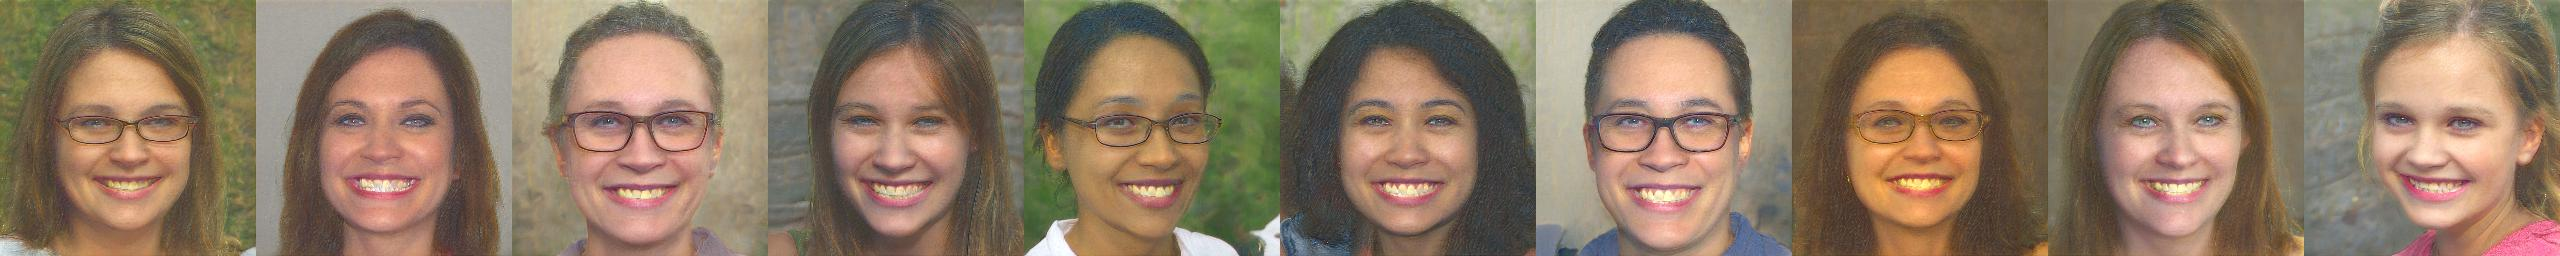

In [ ]:
import numpy as np
from utils import s_space_code_process

batch = 10
codes = np.load("/content/drive/MyDrive/Images/s_transfer_from_z_08_09/TrainRst/08_10_15_56/10_10.npy")
codes = s_space_code_process.parse_codes(codes, 0)

images = easy_synthesis(codes, generator=None, latent_space="S")
_ = imshow(images, batch)

## 隐空间图片生成

In [ ]:
! rm -rf /content/drive/MyDrive/Images/z_08_09_00_55

### 命令行执行

In [ ]:
!python space_generate.py -o /content/drive/MyDrive/Images/z -b 10 -n 1000 --latent_space Z

[2022-08-09 01:00:58,601][INFO] 开始生成图片，一共有100个批次, 从Z空间开始
[2022-08-09 01:00:58,602][INFO] Loading StyleGAN2 model fromcheckpoint/stylegan2-ffhq-config-f.pt
[2022-08-09 01:01:01,691][INFO] Model loaded successfully
[2022-08-09 01:01:01,721][INFO] 成功生成随机样本，样本的类型是<class 'list'>
  0% 0/100 [00:00<?, ?it/s]Sample from Z and transfer to dest space
[2022-08-09 01:01:01,724][INFO] 第0个批次开始生成图片
[2022-08-09 01:01:02,084][INFO] 图片生成完毕
[2022-08-09 01:01:02,084][INFO] 开始保存图片
[2022-08-09 01:01:03,296][INFO] 图片保存完毕
[2022-08-09 01:01:03,296][INFO] 开始保存latent code
[2022-08-09 01:01:03,316][INFO] latent code保存完毕
  1% 1/100 [00:01<02:37,  1.59s/it]Sample from Z and transfer to dest space
[2022-08-09 01:01:03,316][INFO] 第1个批次开始生成图片
[2022-08-09 01:01:03,651][INFO] 图片生成完毕
[2022-08-09 01:01:03,652][INFO] 开始保存图片
[2022-08-09 01:01:04,755][INFO] 图片保存完毕
[2022-08-09 01:01:04,756][INFO] 开始保存latent code
[2022-08-09 01:01:04,760][INFO] latent code保存完毕
  2% 2/100 [00:03<02:27,  1.51s/it]Sample from Z and transfer to de

### jupyter执行

In [ ]:
from space_generate import synthesis
import datetime
import numpy as np

def syn(output_dir, img_num=1000, batch_size=50, input_codes=None, latent_space="Z", random_sample=True):
  output_dir += datetime.datetime.now().strftime('_%m_%d_%H_%M')
  synthesis(output_dir, img_num, batch_size, input_codes, latent_space, random_sample)

### 根据codes生成图片

In [ ]:
from models.model_settings import CHANNELS

def parse_codes(codes, code_type=0):
    """
    将输入的codes解析为list

    :param codes: 输入的codes
    :param code_type: 0-包含style和trgb    1-只包含style    2-只包含trgb
    :return:
    """
    style_codes = []
    trgb_codes = []
    # 起始索引
    idx = 0
    upper_idx = 0
    # 解析第一层
    if code_type == 0 or code_type == 1:
        upper_idx = idx + CHANNELS[4]
        style_codes.append(codes[:, idx:upper_idx])
        idx = upper_idx
    if code_type == 0 or code_type == 2:
        upper_idx = idx + CHANNELS[4]
        trgb_codes.append(codes[:, idx:upper_idx])
        idx = upper_idx

    # 解析剩余层
    for i in range(3, 11):
        if code_type == 0 or code_type == 1:
            upper_idx = idx + CHANNELS[2**(i-1)]
            style_codes.append(codes[:, idx:upper_idx])
            idx = upper_idx

            upper_idx = idx + CHANNELS[2 ** i]
            style_codes.append(codes[:, idx:upper_idx])
            idx = upper_idx
        if code_type == 0 or code_type == 2:
            upper_idx = idx + CHANNELS[2**i]
            trgb_codes.append(codes[:, idx:upper_idx])
            idx = upper_idx

    return [style_codes, trgb_codes]

In [ ]:
import numpy as np
rst = parse_codes(np.load("/content/drive/MyDrive/Images/s_space_07_31_02_20/codes_S/000_s_t.npy"), 0)

syn("/content/drive/MyDrive/Images/s_code", 10, 10, rst, "S", False)

[2022-07-31 03:28:17,997][INFO] 开始生成图片，一共有1个批次, 从S空间开始
[2022-07-31 03:28:17,999][INFO] Loading StyleGAN2 model fromcheckpoint/stylegan2-ffhq-config-f.pt
[2022-07-31 03:28:21,035][INFO] Model loaded successfully
[2022-07-31 03:28:21,048][INFO] 成功生成随机样本，样本的类型是<class 'list'>


  0%|          | 0/1 [00:00<?, ?it/s]

[2022-07-31 03:28:21,055][INFO] 第0个批次开始生成图片
[2022-07-31 03:28:21,427][INFO] 图片生成完毕
[2022-07-31 03:28:21,428][INFO] 开始保存图片
[2022-07-31 03:28:22,621][INFO] 图片保存完毕
[2022-07-31 03:28:22,623][INFO] 开始保存latent code
[2022-07-31 03:28:22,643][INFO] latent code保存完毕


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


### 根据向量生成图片

[2022-07-31 18:57:44,818][INFO] Loading StyleGAN2 model fromcheckpoint/stylegan2-ffhq-config-f.pt


INFO:logger:Loading StyleGAN2 model fromcheckpoint/stylegan2-ffhq-config-f.pt


[2022-07-31 18:57:45,833][INFO] Model loaded successfully


INFO:logger:Model loaded successfully


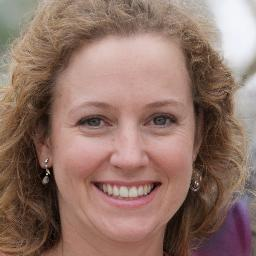

In [ ]:
import numpy as np
from models import stylegan2_generator
normal = np.load("/content/drive/MyDrive/Images/z_07_30_19_02/codes_Z/boundary.npy")

images = easy_synthesis([normal])
images = imshow(images,1)

### 测试代码

In [ ]:
from models import stylegan2_generator

img_num = 20
batch_size = 10
batch_num = 2
g = stylegan2_generator.StyleGAN2Generator()

[2022-07-30 18:45:14,515][INFO] Loading StyleGAN2 model fromcheckpoint/stylegan2-ffhq-config-f.pt
[2022-07-30 18:45:15,261][INFO] Model loaded successfully


In [ ]:
input_codes = g.sample(img_num, latent_space="W")
i=0
inputc = [input_codes[0][i*batch_size:(i+1)*batch_size]]

In [ ]:
print(inputc[0].shape)
print(input_codes[0].shape)
print(input_codes)
print(inputc)

In [ ]:
import torch

codes = inputc
for code in codes:
  print(code)
  print(code.shape)
  print(type(code))

rst = [torch.from_numpy(code).type(torch.FloatTensor).cuda() for code in codes]

In [ ]:
rst

# 生成图片mask

In [ ]:
!rm -rf /content/drive/MyDrive/Images/z_07_30_19_02/masks_border

In [ ]:
#@title { display-mode: "form"}

from generate_mask import gen_mask

#@markdown ### 输入待处理图片所在文件夹:
dir_path = "/content/drive/MyDrive/Images/z_08_09_01_00" #@param {type:"string"}
#@markdown ### 输入需要打分的批次数量:
batch_num = 100 #@param {type:"integer"}
#@markdown （图片的命名格式需要以00X开头）
# gen_mask(dir_path, batch_num)
gen_mask(dir_path, batch_num, use_border=True)

  0%|          | 0/100 [00:00<?, ?it/s]

It takes 0.15635180473327637 to detect with dlib model!
It takes 0.1426248550415039 to detect with dlib model!
It takes 0.1323244571685791 to detect with dlib model!
It takes 0.13460373878479004 to detect with dlib model!
It takes 0.1351933479309082 to detect with dlib model!
It takes 0.13311052322387695 to detect with dlib model!
It takes 0.13097119331359863 to detect with dlib model!
It takes 0.13164281845092773 to detect with dlib model!
It takes 0.13572478294372559 to detect with dlib model!


  1%|          | 1/100 [00:01<03:12,  1.95s/it]

It takes 0.1394650936126709 to detect with dlib model!
It takes 0.28551316261291504 to detect with dlib model!
It takes 0.29912614822387695 to detect with dlib model!
It takes 0.13199329376220703 to detect with dlib model!
It takes 0.1393756866455078 to detect with dlib model!
It takes 0.1422898769378662 to detect with dlib model!
It takes 0.13870501518249512 to detect with dlib model!
It takes 0.133836030960083 to detect with dlib model!
It takes 0.12253689765930176 to detect with dlib model!
It takes 0.14032268524169922 to detect with dlib model!


  2%|▏         | 2/100 [00:04<03:26,  2.10s/it]

It takes 0.13359761238098145 to detect with dlib model!
It takes 0.13722562789916992 to detect with dlib model!
It takes 0.12524199485778809 to detect with dlib model!
It takes 0.12334990501403809 to detect with dlib model!
It takes 0.12684321403503418 to detect with dlib model!
It takes 0.12893986701965332 to detect with dlib model!
It takes 0.1221456527709961 to detect with dlib model!
It takes 0.1251964569091797 to detect with dlib model!
It takes 0.12517857551574707 to detect with dlib model!


  3%|▎         | 3/100 [00:05<03:08,  1.94s/it]

It takes 0.12487292289733887 to detect with dlib model!
It takes 0.12304830551147461 to detect with dlib model!
It takes 0.13575220108032227 to detect with dlib model!
It takes 0.1369943618774414 to detect with dlib model!
It takes 0.13671135902404785 to detect with dlib model!
It takes 0.1468665599822998 to detect with dlib model!
It takes 0.13455843925476074 to detect with dlib model!
It takes 0.14803409576416016 to detect with dlib model!
It takes 0.16858506202697754 to detect with dlib model!
It takes 0.21596360206604004 to detect with dlib model!
It takes 0.2244555950164795 to detect with dlib model!


  4%|▍         | 4/100 [00:08<03:19,  2.08s/it]

It takes 0.2222304344177246 to detect with dlib model!
It takes 0.2215263843536377 to detect with dlib model!
It takes 0.2255861759185791 to detect with dlib model!
It takes 0.22451567649841309 to detect with dlib model!
It takes 0.2250204086303711 to detect with dlib model!
It takes 0.21329760551452637 to detect with dlib model!
It takes 0.22154808044433594 to detect with dlib model!
It takes 0.22124361991882324 to detect with dlib model!
It takes 0.2176055908203125 to detect with dlib model!
It takes 0.2143568992614746 to detect with dlib model!


  5%|▌         | 5/100 [00:11<03:44,  2.36s/it]

It takes 0.22142577171325684 to detect with dlib model!
It takes 0.1608264446258545 to detect with dlib model!
It takes 0.13093090057373047 to detect with dlib model!
It takes 0.13252806663513184 to detect with dlib model!
It takes 0.13731598854064941 to detect with dlib model!
It takes 0.13201618194580078 to detect with dlib model!
It takes 0.13396477699279785 to detect with dlib model!
It takes 0.14754652976989746 to detect with dlib model!
It takes 0.14124345779418945 to detect with dlib model!
It takes 0.1368401050567627 to detect with dlib model!


  6%|▌         | 6/100 [00:12<03:27,  2.21s/it]

It takes 0.1444547176361084 to detect with dlib model!
It takes 0.13163089752197266 to detect with dlib model!
It takes 0.14561915397644043 to detect with dlib model!
It takes 0.1326301097869873 to detect with dlib model!
It takes 0.13416528701782227 to detect with dlib model!
It takes 0.13919639587402344 to detect with dlib model!
It takes 0.1372067928314209 to detect with dlib model!
It takes 0.14257431030273438 to detect with dlib model!
It takes 0.13361716270446777 to detect with dlib model!
It takes 0.13039541244506836 to detect with dlib model!


  7%|▋         | 7/100 [00:14<03:14,  2.09s/it]

It takes 0.13679289817810059 to detect with dlib model!
It takes 0.13459157943725586 to detect with dlib model!
It takes 0.1320497989654541 to detect with dlib model!
It takes 0.13586807250976562 to detect with dlib model!
It takes 0.1345071792602539 to detect with dlib model!
It takes 0.1346437931060791 to detect with dlib model!
It takes 0.14334511756896973 to detect with dlib model!
It takes 0.1333601474761963 to detect with dlib model!
It takes 0.15392327308654785 to detect with dlib model!
It takes 0.1306006908416748 to detect with dlib model!


  8%|▊         | 8/100 [00:16<03:05,  2.02s/it]

It takes 0.1433413028717041 to detect with dlib model!
It takes 0.13374090194702148 to detect with dlib model!
It takes 0.13487768173217773 to detect with dlib model!
It takes 0.1449894905090332 to detect with dlib model!
It takes 0.14291596412658691 to detect with dlib model!
It takes 0.133148193359375 to detect with dlib model!
It takes 0.13878655433654785 to detect with dlib model!
It takes 0.13520264625549316 to detect with dlib model!
It takes 0.1333174705505371 to detect with dlib model!
It takes 0.15794801712036133 to detect with dlib model!


  9%|▉         | 9/100 [00:18<02:59,  1.97s/it]

It takes 0.1347217559814453 to detect with dlib model!
It takes 0.13265633583068848 to detect with dlib model!
It takes 0.13228440284729004 to detect with dlib model!
It takes 0.141615629196167 to detect with dlib model!
It takes 0.14360761642456055 to detect with dlib model!
It takes 0.13462448120117188 to detect with dlib model!
It takes 0.13176417350769043 to detect with dlib model!
It takes 0.13509011268615723 to detect with dlib model!
It takes 0.13272452354431152 to detect with dlib model!
It takes 0.1357114315032959 to detect with dlib model!


 10%|█         | 10/100 [00:20<02:54,  1.94s/it]

It takes 0.1491386890411377 to detect with dlib model!
It takes 0.13834834098815918 to detect with dlib model!
It takes 0.13241171836853027 to detect with dlib model!
It takes 0.14097046852111816 to detect with dlib model!
It takes 0.1490926742553711 to detect with dlib model!
It takes 0.13776588439941406 to detect with dlib model!
It takes 0.1335597038269043 to detect with dlib model!
It takes 0.14075899124145508 to detect with dlib model!
It takes 0.13295722007751465 to detect with dlib model!
It takes 0.1371452808380127 to detect with dlib model!
It takes 0.13353514671325684 to detect with dlib model!


 11%|█         | 11/100 [00:22<02:51,  1.92s/it]

It takes 0.1404585838317871 to detect with dlib model!
It takes 0.1314988136291504 to detect with dlib model!
It takes 0.13202214241027832 to detect with dlib model!
It takes 0.13569378852844238 to detect with dlib model!
It takes 0.13542699813842773 to detect with dlib model!
It takes 0.13693904876708984 to detect with dlib model!
It takes 0.13549423217773438 to detect with dlib model!
It takes 0.13579773902893066 to detect with dlib model!


 12%|█▏        | 12/100 [00:24<02:46,  1.89s/it]

It takes 0.13480281829833984 to detect with dlib model!
It takes 0.13715505599975586 to detect with dlib model!
It takes 0.12915396690368652 to detect with dlib model!
It takes 0.14400076866149902 to detect with dlib model!
It takes 0.13373494148254395 to detect with dlib model!
It takes 0.13469839096069336 to detect with dlib model!
It takes 0.1337907314300537 to detect with dlib model!
It takes 0.14856839179992676 to detect with dlib model!
It takes 0.1576547622680664 to detect with dlib model!
It takes 0.14559245109558105 to detect with dlib model!


 13%|█▎        | 13/100 [00:26<02:44,  1.89s/it]

It takes 0.13311982154846191 to detect with dlib model!
It takes 0.13661932945251465 to detect with dlib model!
It takes 0.1349477767944336 to detect with dlib model!
It takes 0.13133668899536133 to detect with dlib model!
It takes 0.14005208015441895 to detect with dlib model!
It takes 0.13841605186462402 to detect with dlib model!
It takes 0.13359665870666504 to detect with dlib model!
It takes 0.1307685375213623 to detect with dlib model!
It takes 0.13968539237976074 to detect with dlib model!
It takes 0.13889074325561523 to detect with dlib model!


 14%|█▍        | 14/100 [00:27<02:41,  1.88s/it]

It takes 0.1343843936920166 to detect with dlib model!
It takes 0.1327512264251709 to detect with dlib model!
It takes 0.13267898559570312 to detect with dlib model!
It takes 0.122955322265625 to detect with dlib model!
It takes 0.13439345359802246 to detect with dlib model!
It takes 0.12806940078735352 to detect with dlib model!
It takes 0.1226348876953125 to detect with dlib model!
It takes 0.129319429397583 to detect with dlib model!
It takes 0.12566518783569336 to detect with dlib model!
It takes 0.1293783187866211 to detect with dlib model!


 15%|█▌        | 15/100 [00:29<02:36,  1.84s/it]

It takes 0.1277763843536377 to detect with dlib model!
It takes 0.13684487342834473 to detect with dlib model!
It takes 0.12255525588989258 to detect with dlib model!
It takes 0.12170052528381348 to detect with dlib model!
It takes 0.12577581405639648 to detect with dlib model!
It takes 0.12677431106567383 to detect with dlib model!
It takes 0.11939811706542969 to detect with dlib model!
It takes 0.1368412971496582 to detect with dlib model!
It takes 0.12409305572509766 to detect with dlib model!
It takes 0.12107658386230469 to detect with dlib model!


 16%|█▌        | 16/100 [00:31<02:30,  1.79s/it]

It takes 0.12415146827697754 to detect with dlib model!
It takes 0.12434530258178711 to detect with dlib model!
It takes 0.13631319999694824 to detect with dlib model!
It takes 0.1356954574584961 to detect with dlib model!
It takes 0.1285707950592041 to detect with dlib model!
It takes 0.1256270408630371 to detect with dlib model!
It takes 0.12977194786071777 to detect with dlib model!
It takes 0.12143516540527344 to detect with dlib model!
It takes 0.12548303604125977 to detect with dlib model!
It takes 0.2143113613128662 to detect with dlib model!
It takes 0.12622809410095215 to detect with dlib model!


 17%|█▋        | 17/100 [00:33<02:30,  1.81s/it]

It takes 0.1278369426727295 to detect with dlib model!
It takes 0.21343493461608887 to detect with dlib model!
It takes 0.12627768516540527 to detect with dlib model!
It takes 0.1296846866607666 to detect with dlib model!
It takes 0.11959147453308105 to detect with dlib model!
It takes 0.19808244705200195 to detect with dlib model!
It takes 0.12166547775268555 to detect with dlib model!
It takes 0.11729717254638672 to detect with dlib model!
It takes 0.12218284606933594 to detect with dlib model!


 18%|█▊        | 18/100 [00:35<02:29,  1.83s/it]

It takes 0.11723160743713379 to detect with dlib model!
It takes 0.12252259254455566 to detect with dlib model!
It takes 0.12529587745666504 to detect with dlib model!
It takes 0.1250779628753662 to detect with dlib model!
It takes 0.11934423446655273 to detect with dlib model!
It takes 0.13229632377624512 to detect with dlib model!
It takes 0.1268012523651123 to detect with dlib model!
It takes 0.12322783470153809 to detect with dlib model!
It takes 0.12575650215148926 to detect with dlib model!
It takes 0.12008476257324219 to detect with dlib model!
It takes 0.12235426902770996 to detect with dlib model!
It takes 0.12758684158325195 to detect with dlib model!


 19%|█▉        | 19/100 [00:36<02:25,  1.79s/it]

It takes 0.11929702758789062 to detect with dlib model!
It takes 0.12309432029724121 to detect with dlib model!
It takes 0.11962890625 to detect with dlib model!
It takes 0.11878108978271484 to detect with dlib model!
It takes 0.12432122230529785 to detect with dlib model!
It takes 0.13466191291809082 to detect with dlib model!
It takes 0.13355422019958496 to detect with dlib model!
It takes 0.1286790370941162 to detect with dlib model!
It takes 0.12628746032714844 to detect with dlib model!


 20%|██        | 20/100 [00:38<02:22,  1.78s/it]

It takes 0.1284008026123047 to detect with dlib model!
It takes 0.12079238891601562 to detect with dlib model!
It takes 0.12425923347473145 to detect with dlib model!
It takes 0.13089251518249512 to detect with dlib model!
It takes 0.12254214286804199 to detect with dlib model!
It takes 0.12319493293762207 to detect with dlib model!
It takes 0.11908364295959473 to detect with dlib model!
It takes 0.1327223777770996 to detect with dlib model!
It takes 0.12747836112976074 to detect with dlib model!
It takes 0.12392711639404297 to detect with dlib model!


 21%|██        | 21/100 [00:40<02:18,  1.75s/it]

It takes 0.12442398071289062 to detect with dlib model!
It takes 0.1326603889465332 to detect with dlib model!
It takes 0.12250494956970215 to detect with dlib model!
It takes 0.13378334045410156 to detect with dlib model!
It takes 0.1369333267211914 to detect with dlib model!
It takes 0.13135647773742676 to detect with dlib model!
It takes 0.1301097869873047 to detect with dlib model!
It takes 0.12776923179626465 to detect with dlib model!
It takes 0.13242077827453613 to detect with dlib model!
It takes 0.1473255157470703 to detect with dlib model!


 22%|██▏       | 22/100 [00:41<02:18,  1.77s/it]

It takes 0.12650275230407715 to detect with dlib model!
It takes 0.11964654922485352 to detect with dlib model!
It takes 0.12211322784423828 to detect with dlib model!
It takes 0.12546753883361816 to detect with dlib model!
It takes 0.12532877922058105 to detect with dlib model!
It takes 0.13298892974853516 to detect with dlib model!
It takes 0.12566423416137695 to detect with dlib model!
It takes 0.1222538948059082 to detect with dlib model!
It takes 0.12830591201782227 to detect with dlib model!
It takes 0.12419438362121582 to detect with dlib model!


 23%|██▎       | 23/100 [00:43<02:14,  1.75s/it]

It takes 0.12487936019897461 to detect with dlib model!
It takes 0.13843512535095215 to detect with dlib model!
It takes 0.12643074989318848 to detect with dlib model!
It takes 0.12763142585754395 to detect with dlib model!
It takes 0.1316671371459961 to detect with dlib model!
It takes 0.13953447341918945 to detect with dlib model!
It takes 0.13583135604858398 to detect with dlib model!
It takes 0.14238500595092773 to detect with dlib model!
It takes 0.13272619247436523 to detect with dlib model!


 24%|██▍       | 24/100 [00:45<02:14,  1.77s/it]

It takes 0.1337141990661621 to detect with dlib model!
It takes 0.13437628746032715 to detect with dlib model!
It takes 0.13102102279663086 to detect with dlib model!
It takes 0.14195680618286133 to detect with dlib model!
It takes 0.1349201202392578 to detect with dlib model!
It takes 0.14118719100952148 to detect with dlib model!
It takes 0.13248753547668457 to detect with dlib model!
It takes 0.1401052474975586 to detect with dlib model!
It takes 0.13473272323608398 to detect with dlib model!
It takes 0.1470646858215332 to detect with dlib model!
It takes 0.1307988166809082 to detect with dlib model!


 25%|██▌       | 25/100 [00:47<02:15,  1.80s/it]

It takes 0.13581442832946777 to detect with dlib model!
It takes 0.13554763793945312 to detect with dlib model!
It takes 0.13627362251281738 to detect with dlib model!
It takes 0.14561080932617188 to detect with dlib model!
It takes 0.14358997344970703 to detect with dlib model!
It takes 0.15199732780456543 to detect with dlib model!
It takes 0.135512113571167 to detect with dlib model!
It takes 0.136643648147583 to detect with dlib model!
It takes 0.1394188404083252 to detect with dlib model!
It takes 0.13966846466064453 to detect with dlib model!


 26%|██▌       | 26/100 [00:49<02:14,  1.82s/it]

It takes 0.1411139965057373 to detect with dlib model!
It takes 0.13233566284179688 to detect with dlib model!
It takes 0.13389849662780762 to detect with dlib model!
It takes 0.1371474266052246 to detect with dlib model!
It takes 0.14908337593078613 to detect with dlib model!
It takes 0.13612675666809082 to detect with dlib model!
It takes 0.13758206367492676 to detect with dlib model!
It takes 0.12846946716308594 to detect with dlib model!
It takes 0.1362912654876709 to detect with dlib model!


 27%|██▋       | 27/100 [00:51<02:13,  1.83s/it]

It takes 0.13260173797607422 to detect with dlib model!
It takes 0.12937569618225098 to detect with dlib model!
It takes 0.13854742050170898 to detect with dlib model!
It takes 0.1308910846710205 to detect with dlib model!
It takes 0.1339702606201172 to detect with dlib model!
It takes 0.13799142837524414 to detect with dlib model!
It takes 0.14297223091125488 to detect with dlib model!
It takes 0.13259005546569824 to detect with dlib model!
It takes 0.133544921875 to detect with dlib model!
It takes 0.13913226127624512 to detect with dlib model!


 28%|██▊       | 28/100 [00:52<02:11,  1.83s/it]

It takes 0.1321113109588623 to detect with dlib model!
It takes 0.13355159759521484 to detect with dlib model!
It takes 0.13867473602294922 to detect with dlib model!
It takes 0.13992714881896973 to detect with dlib model!
It takes 0.13319110870361328 to detect with dlib model!
It takes 0.13477754592895508 to detect with dlib model!
It takes 0.13410186767578125 to detect with dlib model!
It takes 0.1431598663330078 to detect with dlib model!
It takes 0.13647174835205078 to detect with dlib model!
It takes 0.12980127334594727 to detect with dlib model!
It takes 0.13940191268920898 to detect with dlib model!


 29%|██▉       | 29/100 [00:54<02:10,  1.84s/it]

It takes 0.13505864143371582 to detect with dlib model!
It takes 0.14282488822937012 to detect with dlib model!
It takes 0.14199113845825195 to detect with dlib model!
It takes 0.13850665092468262 to detect with dlib model!
It takes 0.1339402198791504 to detect with dlib model!
It takes 0.14521479606628418 to detect with dlib model!
It takes 0.13859963417053223 to detect with dlib model!
It takes 0.14579105377197266 to detect with dlib model!
It takes 0.1433115005493164 to detect with dlib model!
It takes 0.1412508487701416 to detect with dlib model!
It takes 0.14061284065246582 to detect with dlib model!


 30%|███       | 30/100 [00:56<02:10,  1.87s/it]

It takes 0.13265395164489746 to detect with dlib model!
It takes 0.14105224609375 to detect with dlib model!
It takes 0.1361103057861328 to detect with dlib model!
It takes 0.17392921447753906 to detect with dlib model!
It takes 0.1291491985321045 to detect with dlib model!
It takes 0.13731718063354492 to detect with dlib model!
It takes 0.12981295585632324 to detect with dlib model!
It takes 0.12969136238098145 to detect with dlib model!
It takes 0.13222122192382812 to detect with dlib model!


 31%|███       | 31/100 [00:58<02:07,  1.85s/it]

It takes 0.12923359870910645 to detect with dlib model!
It takes 0.12929511070251465 to detect with dlib model!
It takes 0.1201779842376709 to detect with dlib model!
It takes 0.12776947021484375 to detect with dlib model!
It takes 0.14155006408691406 to detect with dlib model!
It takes 0.12773656845092773 to detect with dlib model!
It takes 0.13126420974731445 to detect with dlib model!
It takes 0.12549662590026855 to detect with dlib model!
It takes 0.13126420974731445 to detect with dlib model!
It takes 0.14048433303833008 to detect with dlib model!


 32%|███▏      | 32/100 [01:00<02:04,  1.83s/it]

It takes 0.12519288063049316 to detect with dlib model!
It takes 0.1259002685546875 to detect with dlib model!
It takes 0.12307357788085938 to detect with dlib model!
It takes 0.13225364685058594 to detect with dlib model!
It takes 0.1256701946258545 to detect with dlib model!
It takes 0.1408858299255371 to detect with dlib model!
It takes 0.12227773666381836 to detect with dlib model!
It takes 0.13184666633605957 to detect with dlib model!
It takes 0.12645268440246582 to detect with dlib model!
It takes 0.12345457077026367 to detect with dlib model!


 33%|███▎      | 33/100 [01:02<02:00,  1.81s/it]

It takes 0.13100123405456543 to detect with dlib model!
It takes 0.13177132606506348 to detect with dlib model!
It takes 0.13568401336669922 to detect with dlib model!
It takes 0.1341233253479004 to detect with dlib model!
It takes 0.13248991966247559 to detect with dlib model!
It takes 0.1367025375366211 to detect with dlib model!
It takes 0.14896917343139648 to detect with dlib model!
It takes 0.1348428726196289 to detect with dlib model!
It takes 0.1351931095123291 to detect with dlib model!


 34%|███▍      | 34/100 [01:03<02:00,  1.82s/it]

It takes 0.13188648223876953 to detect with dlib model!
It takes 0.13843870162963867 to detect with dlib model!
It takes 0.13003301620483398 to detect with dlib model!
It takes 0.14068150520324707 to detect with dlib model!
It takes 0.13988900184631348 to detect with dlib model!
It takes 0.1307370662689209 to detect with dlib model!
It takes 0.13795161247253418 to detect with dlib model!
It takes 0.1367650032043457 to detect with dlib model!
It takes 0.133392333984375 to detect with dlib model!
It takes 0.13712835311889648 to detect with dlib model!


 35%|███▌      | 35/100 [01:05<01:59,  1.84s/it]

It takes 0.13528084754943848 to detect with dlib model!
It takes 0.13713455200195312 to detect with dlib model!
It takes 0.13259482383728027 to detect with dlib model!
It takes 0.1370553970336914 to detect with dlib model!
It takes 0.13399338722229004 to detect with dlib model!
It takes 0.14148783683776855 to detect with dlib model!
It takes 0.13092470169067383 to detect with dlib model!
It takes 0.1371612548828125 to detect with dlib model!
It takes 0.13232684135437012 to detect with dlib model!
It takes 0.13231301307678223 to detect with dlib model!


 36%|███▌      | 36/100 [01:07<01:57,  1.83s/it]

It takes 0.12958765029907227 to detect with dlib model!
It takes 0.133528470993042 to detect with dlib model!
It takes 0.1339418888092041 to detect with dlib model!
It takes 0.14020228385925293 to detect with dlib model!
It takes 0.13243818283081055 to detect with dlib model!
It takes 0.14401888847351074 to detect with dlib model!
It takes 0.13347482681274414 to detect with dlib model!
It takes 0.13381195068359375 to detect with dlib model!
It takes 0.13365721702575684 to detect with dlib model!
It takes 0.14806175231933594 to detect with dlib model!
It takes 0.1322171688079834 to detect with dlib model!
It takes 0.1472606658935547 to detect with dlib model!


 37%|███▋      | 37/100 [01:09<01:56,  1.85s/it]

It takes 0.13231468200683594 to detect with dlib model!
It takes 0.13815593719482422 to detect with dlib model!
It takes 0.13373208045959473 to detect with dlib model!
It takes 0.13378119468688965 to detect with dlib model!
It takes 0.1411283016204834 to detect with dlib model!
It takes 0.13454556465148926 to detect with dlib model!
It takes 0.1357741355895996 to detect with dlib model!
It takes 0.13170242309570312 to detect with dlib model!


 38%|███▊      | 38/100 [01:11<01:54,  1.84s/it]

It takes 0.13173651695251465 to detect with dlib model!
It takes 0.13343262672424316 to detect with dlib model!
It takes 0.1309499740600586 to detect with dlib model!
It takes 0.13906264305114746 to detect with dlib model!
It takes 0.1352846622467041 to detect with dlib model!
It takes 0.13400721549987793 to detect with dlib model!
It takes 0.1372699737548828 to detect with dlib model!
It takes 0.13384556770324707 to detect with dlib model!
It takes 0.14104628562927246 to detect with dlib model!
It takes 0.13404607772827148 to detect with dlib model!


 39%|███▉      | 39/100 [01:13<01:53,  1.86s/it]

It takes 0.14217090606689453 to detect with dlib model!
It takes 0.14261913299560547 to detect with dlib model!
It takes 0.15443944931030273 to detect with dlib model!
It takes 0.13420796394348145 to detect with dlib model!
It takes 0.13848352432250977 to detect with dlib model!
It takes 0.14019298553466797 to detect with dlib model!
It takes 0.13640666007995605 to detect with dlib model!
It takes 0.14321422576904297 to detect with dlib model!
It takes 0.14026618003845215 to detect with dlib model!
It takes 0.13689899444580078 to detect with dlib model!


 40%|████      | 40/100 [01:15<01:52,  1.87s/it]

It takes 0.1352999210357666 to detect with dlib model!
It takes 0.13223791122436523 to detect with dlib model!
It takes 0.1380143165588379 to detect with dlib model!
It takes 0.14143824577331543 to detect with dlib model!
It takes 0.13638925552368164 to detect with dlib model!
It takes 0.13612914085388184 to detect with dlib model!
It takes 0.13118934631347656 to detect with dlib model!
It takes 0.14278745651245117 to detect with dlib model!
It takes 0.1389179229736328 to detect with dlib model!
It takes 0.13568830490112305 to detect with dlib model!


 41%|████      | 41/100 [01:17<01:50,  1.87s/it]

It takes 0.1304924488067627 to detect with dlib model!
It takes 0.1361832618713379 to detect with dlib model!
It takes 0.14111709594726562 to detect with dlib model!
It takes 0.1360924243927002 to detect with dlib model!
It takes 0.1392688751220703 to detect with dlib model!
It takes 0.13857483863830566 to detect with dlib model!
It takes 0.13242769241333008 to detect with dlib model!
It takes 0.13216400146484375 to detect with dlib model!
It takes 0.1616659164428711 to detect with dlib model!
It takes 0.1468954086303711 to detect with dlib model!


 42%|████▏     | 42/100 [01:18<01:48,  1.87s/it]

It takes 0.12933588027954102 to detect with dlib model!
It takes 0.1364457607269287 to detect with dlib model!
It takes 0.13599824905395508 to detect with dlib model!
It takes 0.13425922393798828 to detect with dlib model!
It takes 0.14746332168579102 to detect with dlib model!
It takes 0.14397716522216797 to detect with dlib model!
It takes 0.13985037803649902 to detect with dlib model!
It takes 0.1421966552734375 to detect with dlib model!
It takes 0.13550353050231934 to detect with dlib model!
It takes 0.14142417907714844 to detect with dlib model!


 43%|████▎     | 43/100 [01:20<01:47,  1.88s/it]

It takes 0.14449739456176758 to detect with dlib model!
It takes 0.1403484344482422 to detect with dlib model!
It takes 0.1381826400756836 to detect with dlib model!
It takes 0.1395566463470459 to detect with dlib model!
It takes 0.13013172149658203 to detect with dlib model!
It takes 0.13456463813781738 to detect with dlib model!
It takes 0.13150620460510254 to detect with dlib model!
It takes 0.13525700569152832 to detect with dlib model!
It takes 0.13172578811645508 to detect with dlib model!
It takes 0.13879728317260742 to detect with dlib model!
It takes 0.13453102111816406 to detect with dlib model!


 44%|████▍     | 44/100 [01:22<01:45,  1.88s/it]

It takes 0.1392965316772461 to detect with dlib model!
It takes 0.12526202201843262 to detect with dlib model!
It takes 0.1307373046875 to detect with dlib model!
It takes 0.1470506191253662 to detect with dlib model!
It takes 0.1311337947845459 to detect with dlib model!
It takes 0.1222374439239502 to detect with dlib model!
It takes 0.13506245613098145 to detect with dlib model!
It takes 0.12087202072143555 to detect with dlib model!
It takes 0.13274908065795898 to detect with dlib model!
It takes 0.13362598419189453 to detect with dlib model!


 45%|████▌     | 45/100 [01:24<01:42,  1.86s/it]

It takes 0.13407492637634277 to detect with dlib model!
It takes 0.14829802513122559 to detect with dlib model!
It takes 0.12804913520812988 to detect with dlib model!
It takes 0.13453006744384766 to detect with dlib model!
It takes 0.12436795234680176 to detect with dlib model!
It takes 0.1264328956604004 to detect with dlib model!
It takes 0.12676143646240234 to detect with dlib model!
It takes 0.13564777374267578 to detect with dlib model!
It takes 0.14123249053955078 to detect with dlib model!


 46%|████▌     | 46/100 [01:26<01:39,  1.84s/it]

It takes 0.1283128261566162 to detect with dlib model!
It takes 0.13936972618103027 to detect with dlib model!
It takes 0.13255596160888672 to detect with dlib model!
It takes 0.13465547561645508 to detect with dlib model!
It takes 0.1364288330078125 to detect with dlib model!
It takes 0.14047527313232422 to detect with dlib model!
It takes 0.12740731239318848 to detect with dlib model!
It takes 0.13009881973266602 to detect with dlib model!
It takes 0.12287759780883789 to detect with dlib model!
It takes 0.1407163143157959 to detect with dlib model!
It takes 0.12613606452941895 to detect with dlib model!


 47%|████▋     | 47/100 [01:28<01:37,  1.83s/it]

It takes 0.129258394241333 to detect with dlib model!
It takes 0.13121747970581055 to detect with dlib model!
It takes 0.12858223915100098 to detect with dlib model!
It takes 0.12692999839782715 to detect with dlib model!
It takes 0.1325998306274414 to detect with dlib model!
It takes 0.13027215003967285 to detect with dlib model!
It takes 0.13162660598754883 to detect with dlib model!
It takes 0.13293743133544922 to detect with dlib model!
It takes 0.12729239463806152 to detect with dlib model!
It takes 0.13489603996276855 to detect with dlib model!


 48%|████▊     | 48/100 [01:29<01:34,  1.82s/it]

It takes 0.13128662109375 to detect with dlib model!
It takes 0.13494110107421875 to detect with dlib model!
It takes 0.12217259407043457 to detect with dlib model!
It takes 0.12449526786804199 to detect with dlib model!
It takes 0.12099027633666992 to detect with dlib model!
It takes 0.1257164478302002 to detect with dlib model!
It takes 0.12105369567871094 to detect with dlib model!
It takes 0.1252584457397461 to detect with dlib model!
It takes 0.12755250930786133 to detect with dlib model!


 49%|████▉     | 49/100 [01:31<01:31,  1.79s/it]

It takes 0.12006545066833496 to detect with dlib model!
It takes 0.1261754035949707 to detect with dlib model!
It takes 0.12255525588989258 to detect with dlib model!
It takes 0.13899588584899902 to detect with dlib model!
It takes 0.12490987777709961 to detect with dlib model!
It takes 0.1303088665008545 to detect with dlib model!
It takes 0.12906718254089355 to detect with dlib model!
It takes 0.13728117942810059 to detect with dlib model!
It takes 0.1403195858001709 to detect with dlib model!
It takes 0.12265658378601074 to detect with dlib model!


 50%|█████     | 50/100 [01:33<01:29,  1.78s/it]

It takes 0.12302350997924805 to detect with dlib model!
It takes 0.12743639945983887 to detect with dlib model!
It takes 0.11943435668945312 to detect with dlib model!
It takes 0.13408923149108887 to detect with dlib model!
It takes 0.12316560745239258 to detect with dlib model!
It takes 0.12736988067626953 to detect with dlib model!
It takes 0.1226663589477539 to detect with dlib model!
It takes 0.12082242965698242 to detect with dlib model!
It takes 0.13086390495300293 to detect with dlib model!
It takes 0.12517070770263672 to detect with dlib model!


 51%|█████     | 51/100 [01:35<01:26,  1.77s/it]

It takes 0.13202595710754395 to detect with dlib model!
It takes 0.13378548622131348 to detect with dlib model!
It takes 0.12490725517272949 to detect with dlib model!
It takes 0.11841845512390137 to detect with dlib model!
It takes 0.12121248245239258 to detect with dlib model!
It takes 0.1189875602722168 to detect with dlib model!
It takes 0.12935543060302734 to detect with dlib model!
It takes 0.12004303932189941 to detect with dlib model!
It takes 0.1371631622314453 to detect with dlib model!
It takes 0.12914466857910156 to detect with dlib model!


 52%|█████▏    | 52/100 [01:36<01:24,  1.76s/it]

It takes 0.1346588134765625 to detect with dlib model!
It takes 0.12142562866210938 to detect with dlib model!
It takes 0.13046503067016602 to detect with dlib model!
It takes 0.12918901443481445 to detect with dlib model!
It takes 0.12199640274047852 to detect with dlib model!
It takes 0.1299450397491455 to detect with dlib model!
It takes 0.12639379501342773 to detect with dlib model!
It takes 0.1224665641784668 to detect with dlib model!
It takes 0.13175415992736816 to detect with dlib model!
It takes 0.13080430030822754 to detect with dlib model!


 53%|█████▎    | 53/100 [01:38<01:22,  1.76s/it]

It takes 0.12931370735168457 to detect with dlib model!
It takes 0.1273326873779297 to detect with dlib model!
It takes 0.12357568740844727 to detect with dlib model!
It takes 0.12947583198547363 to detect with dlib model!
It takes 0.1792147159576416 to detect with dlib model!
It takes 0.2129497528076172 to detect with dlib model!
It takes 0.1980280876159668 to detect with dlib model!
It takes 0.19966912269592285 to detect with dlib model!
It takes 0.2089836597442627 to detect with dlib model!
It takes 0.20258307456970215 to detect with dlib model!
It takes 0.1991252899169922 to detect with dlib model!


 54%|█████▍    | 54/100 [01:41<01:30,  1.97s/it]

It takes 0.208662748336792 to detect with dlib model!
It takes 0.1936478614807129 to detect with dlib model!
It takes 0.2008066177368164 to detect with dlib model!
It takes 0.21298909187316895 to detect with dlib model!
It takes 0.20789623260498047 to detect with dlib model!
It takes 0.24259281158447266 to detect with dlib model!
It takes 0.20098018646240234 to detect with dlib model!
It takes 0.2039628028869629 to detect with dlib model!
It takes 0.1279125213623047 to detect with dlib model!


 55%|█████▌    | 55/100 [01:43<01:34,  2.09s/it]

It takes 0.12470531463623047 to detect with dlib model!
It takes 0.12353658676147461 to detect with dlib model!
It takes 0.12952351570129395 to detect with dlib model!
It takes 0.12633037567138672 to detect with dlib model!
It takes 0.12952303886413574 to detect with dlib model!
It takes 0.13125848770141602 to detect with dlib model!
It takes 0.12668800354003906 to detect with dlib model!
It takes 0.12029576301574707 to detect with dlib model!
It takes 0.1272566318511963 to detect with dlib model!
It takes 0.12233877182006836 to detect with dlib model!


 56%|█████▌    | 56/100 [01:45<01:27,  1.98s/it]

It takes 0.12729144096374512 to detect with dlib model!
It takes 0.12623310089111328 to detect with dlib model!
It takes 0.12938809394836426 to detect with dlib model!
It takes 0.13318777084350586 to detect with dlib model!
It takes 0.13489103317260742 to detect with dlib model!
It takes 0.1326136589050293 to detect with dlib model!
It takes 0.14307451248168945 to detect with dlib model!
It takes 0.13442564010620117 to detect with dlib model!
It takes 0.1437511444091797 to detect with dlib model!
It takes 0.13745427131652832 to detect with dlib model!
It takes 0.13479208946228027 to detect with dlib model!


 57%|█████▋    | 57/100 [01:47<01:23,  1.95s/it]

It takes 0.13485026359558105 to detect with dlib model!
It takes 0.1445600986480713 to detect with dlib model!
It takes 0.14715909957885742 to detect with dlib model!
It takes 0.1407458782196045 to detect with dlib model!
It takes 0.13130927085876465 to detect with dlib model!
It takes 0.14353346824645996 to detect with dlib model!
It takes 0.1459333896636963 to detect with dlib model!
It takes 0.14582061767578125 to detect with dlib model!
It takes 0.13210773468017578 to detect with dlib model!


 58%|█████▊    | 58/100 [01:48<01:21,  1.94s/it]

It takes 0.1411607265472412 to detect with dlib model!
It takes 0.1348705291748047 to detect with dlib model!
It takes 0.13601088523864746 to detect with dlib model!
It takes 0.13867545127868652 to detect with dlib model!
It takes 0.13618946075439453 to detect with dlib model!
It takes 0.13687419891357422 to detect with dlib model!
It takes 0.13518977165222168 to detect with dlib model!
It takes 0.13785219192504883 to detect with dlib model!
It takes 0.14499950408935547 to detect with dlib model!
It takes 0.1356356143951416 to detect with dlib model!


 59%|█████▉    | 59/100 [01:50<01:18,  1.91s/it]

It takes 0.13374805450439453 to detect with dlib model!
It takes 0.1351184844970703 to detect with dlib model!
It takes 0.14530706405639648 to detect with dlib model!
It takes 0.1473681926727295 to detect with dlib model!
It takes 0.13167691230773926 to detect with dlib model!
It takes 0.1369645595550537 to detect with dlib model!
It takes 0.1343224048614502 to detect with dlib model!
It takes 0.13885760307312012 to detect with dlib model!
It takes 0.1412358283996582 to detect with dlib model!
It takes 0.13549375534057617 to detect with dlib model!
It takes 0.13309574127197266 to detect with dlib model!


 60%|██████    | 60/100 [01:52<01:16,  1.92s/it]

It takes 0.1360304355621338 to detect with dlib model!
It takes 0.12907862663269043 to detect with dlib model!
It takes 0.13434386253356934 to detect with dlib model!
It takes 0.14238882064819336 to detect with dlib model!
It takes 0.1255347728729248 to detect with dlib model!
It takes 0.13241314888000488 to detect with dlib model!
It takes 0.1251380443572998 to detect with dlib model!
It takes 0.12758660316467285 to detect with dlib model!
It takes 0.12869477272033691 to detect with dlib model!
It takes 0.1430215835571289 to detect with dlib model!


 61%|██████    | 61/100 [01:54<01:13,  1.88s/it]

It takes 0.13012981414794922 to detect with dlib model!
It takes 0.14389872550964355 to detect with dlib model!
It takes 0.13274455070495605 to detect with dlib model!
It takes 0.1346273422241211 to detect with dlib model!
It takes 0.1335129737854004 to detect with dlib model!
It takes 0.13279128074645996 to detect with dlib model!
It takes 0.1301729679107666 to detect with dlib model!
It takes 0.1307971477508545 to detect with dlib model!
It takes 0.1283574104309082 to detect with dlib model!


 62%|██████▏   | 62/100 [01:56<01:10,  1.85s/it]

It takes 0.12413406372070312 to detect with dlib model!
It takes 0.14261603355407715 to detect with dlib model!
It takes 0.13066935539245605 to detect with dlib model!
It takes 0.13538885116577148 to detect with dlib model!
It takes 0.1358025074005127 to detect with dlib model!
It takes 0.14379668235778809 to detect with dlib model!
It takes 0.13703513145446777 to detect with dlib model!
It takes 0.13881945610046387 to detect with dlib model!
It takes 0.1377265453338623 to detect with dlib model!
It takes 0.1309962272644043 to detect with dlib model!


 63%|██████▎   | 63/100 [01:58<01:08,  1.85s/it]

It takes 0.13086652755737305 to detect with dlib model!
It takes 0.13105344772338867 to detect with dlib model!
It takes 0.14087224006652832 to detect with dlib model!
It takes 0.13319993019104004 to detect with dlib model!
It takes 0.12500214576721191 to detect with dlib model!
It takes 0.13454222679138184 to detect with dlib model!
It takes 0.13599109649658203 to detect with dlib model!
It takes 0.13562512397766113 to detect with dlib model!
It takes 0.12956929206848145 to detect with dlib model!
It takes 0.12673258781433105 to detect with dlib model!


 64%|██████▍   | 64/100 [01:59<01:06,  1.83s/it]

It takes 0.12536907196044922 to detect with dlib model!
It takes 0.1290280818939209 to detect with dlib model!
It takes 0.14821434020996094 to detect with dlib model!
It takes 0.12846016883850098 to detect with dlib model!
It takes 0.12892508506774902 to detect with dlib model!
It takes 0.1334550380706787 to detect with dlib model!
It takes 0.15267562866210938 to detect with dlib model!
It takes 0.12907624244689941 to detect with dlib model!
It takes 0.13350462913513184 to detect with dlib model!
It takes 0.1348552703857422 to detect with dlib model!


 65%|██████▌   | 65/100 [02:01<01:04,  1.85s/it]

It takes 0.13215231895446777 to detect with dlib model!
It takes 0.13725781440734863 to detect with dlib model!
It takes 0.13991260528564453 to detect with dlib model!
It takes 0.13520407676696777 to detect with dlib model!
It takes 0.14428997039794922 to detect with dlib model!
It takes 0.14010977745056152 to detect with dlib model!
It takes 0.13602924346923828 to detect with dlib model!
It takes 0.14277124404907227 to detect with dlib model!
It takes 0.13497090339660645 to detect with dlib model!
It takes 0.13757085800170898 to detect with dlib model!
It takes 0.1421060562133789 to detect with dlib model!
It takes 0.1352219581604004 to detect with dlib model!


 66%|██████▌   | 66/100 [02:03<01:03,  1.86s/it]

It takes 0.13261747360229492 to detect with dlib model!
It takes 0.13687801361083984 to detect with dlib model!
It takes 0.137847900390625 to detect with dlib model!
It takes 0.15164828300476074 to detect with dlib model!
It takes 0.14118266105651855 to detect with dlib model!
It takes 0.1347644329071045 to detect with dlib model!
It takes 0.13515639305114746 to detect with dlib model!
It takes 0.13861298561096191 to detect with dlib model!


 67%|██████▋   | 67/100 [02:05<01:01,  1.87s/it]

It takes 0.13492989540100098 to detect with dlib model!
It takes 0.13442516326904297 to detect with dlib model!
It takes 0.27854442596435547 to detect with dlib model!
It takes 0.2244408130645752 to detect with dlib model!
It takes 0.15367531776428223 to detect with dlib model!
It takes 0.1318223476409912 to detect with dlib model!
It takes 0.1356949806213379 to detect with dlib model!
It takes 0.13389277458190918 to detect with dlib model!
It takes 0.14014124870300293 to detect with dlib model!
It takes 0.13420557975769043 to detect with dlib model!


 68%|██████▊   | 68/100 [02:07<01:02,  1.97s/it]

It takes 0.1435847282409668 to detect with dlib model!
It takes 0.13521099090576172 to detect with dlib model!
It takes 0.13535666465759277 to detect with dlib model!
It takes 0.13299202919006348 to detect with dlib model!
It takes 0.14516401290893555 to detect with dlib model!
It takes 0.14107346534729004 to detect with dlib model!
It takes 0.1327986717224121 to detect with dlib model!
It takes 0.13129425048828125 to detect with dlib model!
It takes 0.13595318794250488 to detect with dlib model!
It takes 0.13233423233032227 to detect with dlib model!


 69%|██████▉   | 69/100 [02:09<00:59,  1.93s/it]

It takes 0.1336367130279541 to detect with dlib model!
It takes 0.1366257667541504 to detect with dlib model!
It takes 0.13777995109558105 to detect with dlib model!
It takes 0.13292574882507324 to detect with dlib model!
It takes 0.13571977615356445 to detect with dlib model!
It takes 0.1393260955810547 to detect with dlib model!
It takes 0.1442112922668457 to detect with dlib model!
It takes 0.1359250545501709 to detect with dlib model!
It takes 0.13501644134521484 to detect with dlib model!
It takes 0.12842679023742676 to detect with dlib model!
It takes 0.13161659240722656 to detect with dlib model!


 70%|███████   | 70/100 [02:11<00:57,  1.91s/it]

It takes 0.13112115859985352 to detect with dlib model!
It takes 0.13462591171264648 to detect with dlib model!
It takes 0.1461021900177002 to detect with dlib model!
It takes 0.13374781608581543 to detect with dlib model!
It takes 0.1382732391357422 to detect with dlib model!
It takes 0.13666725158691406 to detect with dlib model!
It takes 0.15079736709594727 to detect with dlib model!
It takes 0.14262938499450684 to detect with dlib model!
It takes 0.13814616203308105 to detect with dlib model!
It takes 0.1373298168182373 to detect with dlib model!


 71%|███████   | 71/100 [02:13<00:55,  1.91s/it]

It takes 0.13813447952270508 to detect with dlib model!
It takes 0.14498662948608398 to detect with dlib model!
It takes 0.1478583812713623 to detect with dlib model!
It takes 0.13181567192077637 to detect with dlib model!
It takes 0.135239839553833 to detect with dlib model!
It takes 0.12931227684020996 to detect with dlib model!
It takes 0.13835978507995605 to detect with dlib model!
It takes 0.13821983337402344 to detect with dlib model!
It takes 0.12882757186889648 to detect with dlib model!


 72%|███████▏  | 72/100 [02:15<00:52,  1.89s/it]

It takes 0.13576626777648926 to detect with dlib model!
It takes 0.13509488105773926 to detect with dlib model!
It takes 0.13866639137268066 to detect with dlib model!
It takes 0.14539527893066406 to detect with dlib model!
It takes 0.13384175300598145 to detect with dlib model!
It takes 0.1334066390991211 to detect with dlib model!
It takes 0.14061570167541504 to detect with dlib model!
It takes 0.14434242248535156 to detect with dlib model!
It takes 0.1436753273010254 to detect with dlib model!
It takes 0.14470791816711426 to detect with dlib model!


 73%|███████▎  | 73/100 [02:17<00:51,  1.90s/it]

It takes 0.14603757858276367 to detect with dlib model!
It takes 0.13530540466308594 to detect with dlib model!
It takes 0.13638043403625488 to detect with dlib model!
It takes 0.1318364143371582 to detect with dlib model!
It takes 0.14024138450622559 to detect with dlib model!
It takes 0.1328439712524414 to detect with dlib model!
It takes 0.13370871543884277 to detect with dlib model!
It takes 0.13248634338378906 to detect with dlib model!
It takes 0.13022875785827637 to detect with dlib model!
It takes 0.1361844539642334 to detect with dlib model!


 74%|███████▍  | 74/100 [02:19<00:49,  1.89s/it]

It takes 0.1346454620361328 to detect with dlib model!
It takes 0.1347057819366455 to detect with dlib model!
It takes 0.13390064239501953 to detect with dlib model!
It takes 0.1315627098083496 to detect with dlib model!
It takes 0.13143658638000488 to detect with dlib model!
It takes 0.1389446258544922 to detect with dlib model!
It takes 0.13271689414978027 to detect with dlib model!
It takes 0.13560748100280762 to detect with dlib model!
It takes 0.13707828521728516 to detect with dlib model!
It takes 0.14239978790283203 to detect with dlib model!
It takes 0.13216233253479004 to detect with dlib model!
It takes 0.1411447525024414 to detect with dlib model!


 75%|███████▌  | 75/100 [02:20<00:47,  1.89s/it]

It takes 0.13660931587219238 to detect with dlib model!
It takes 0.13733386993408203 to detect with dlib model!
It takes 0.1381237506866455 to detect with dlib model!
It takes 0.13541221618652344 to detect with dlib model!
It takes 0.13623380661010742 to detect with dlib model!
It takes 0.1433117389678955 to detect with dlib model!
It takes 0.13702130317687988 to detect with dlib model!
It takes 0.13742923736572266 to detect with dlib model!
It takes 0.13477063179016113 to detect with dlib model!


 76%|███████▌  | 76/100 [02:22<00:45,  1.91s/it]

It takes 0.14716005325317383 to detect with dlib model!
It takes 0.1312265396118164 to detect with dlib model!
It takes 0.1355278491973877 to detect with dlib model!
It takes 0.1339092254638672 to detect with dlib model!
It takes 0.1344313621520996 to detect with dlib model!
It takes 0.14345908164978027 to detect with dlib model!
It takes 0.13380098342895508 to detect with dlib model!
It takes 0.13353943824768066 to detect with dlib model!
It takes 0.13277459144592285 to detect with dlib model!
It takes 0.12709593772888184 to detect with dlib model!


 77%|███████▋  | 77/100 [02:24<00:43,  1.89s/it]

It takes 0.14541983604431152 to detect with dlib model!
It takes 0.13419818878173828 to detect with dlib model!
It takes 0.133469820022583 to detect with dlib model!
It takes 0.12848663330078125 to detect with dlib model!
It takes 0.13321304321289062 to detect with dlib model!
It takes 0.12779569625854492 to detect with dlib model!
It takes 0.13258123397827148 to detect with dlib model!
It takes 0.13085103034973145 to detect with dlib model!
It takes 0.12413740158081055 to detect with dlib model!
It takes 0.12744688987731934 to detect with dlib model!


 78%|███████▊  | 78/100 [02:26<00:40,  1.86s/it]

It takes 0.13435888290405273 to detect with dlib model!
It takes 0.1231238842010498 to detect with dlib model!
It takes 0.1397085189819336 to detect with dlib model!
It takes 0.1287698745727539 to detect with dlib model!
It takes 0.13083219528198242 to detect with dlib model!
It takes 0.1379413604736328 to detect with dlib model!
It takes 0.13826751708984375 to detect with dlib model!
It takes 0.13309001922607422 to detect with dlib model!
It takes 0.1389322280883789 to detect with dlib model!
It takes 0.13513755798339844 to detect with dlib model!


 79%|███████▉  | 79/100 [02:28<00:38,  1.85s/it]

It takes 0.12436246871948242 to detect with dlib model!
It takes 0.13822364807128906 to detect with dlib model!
It takes 0.11904215812683105 to detect with dlib model!
It takes 0.12860727310180664 to detect with dlib model!
It takes 0.12557268142700195 to detect with dlib model!
It takes 0.13025712966918945 to detect with dlib model!
It takes 0.12238693237304688 to detect with dlib model!
It takes 0.12217211723327637 to detect with dlib model!
It takes 0.125718355178833 to detect with dlib model!


 80%|████████  | 80/100 [02:30<00:36,  1.81s/it]

It takes 0.12213873863220215 to detect with dlib model!
It takes 0.12702536582946777 to detect with dlib model!
It takes 0.12661123275756836 to detect with dlib model!
It takes 0.11971163749694824 to detect with dlib model!
It takes 0.12777161598205566 to detect with dlib model!
It takes 0.13501262664794922 to detect with dlib model!
It takes 0.1371471881866455 to detect with dlib model!
It takes 0.1232149600982666 to detect with dlib model!
It takes 0.12651848793029785 to detect with dlib model!
It takes 0.12261557579040527 to detect with dlib model!


 81%|████████  | 81/100 [02:31<00:34,  1.80s/it]

It takes 0.12735748291015625 to detect with dlib model!
It takes 0.1286153793334961 to detect with dlib model!
It takes 0.13770842552185059 to detect with dlib model!
It takes 0.12342667579650879 to detect with dlib model!
It takes 0.13023805618286133 to detect with dlib model!
It takes 0.14199495315551758 to detect with dlib model!
It takes 0.12798643112182617 to detect with dlib model!
It takes 0.12286639213562012 to detect with dlib model!
It takes 0.12933588027954102 to detect with dlib model!
It takes 0.12097740173339844 to detect with dlib model!


 82%|████████▏ | 82/100 [02:33<00:32,  1.78s/it]

It takes 0.12481999397277832 to detect with dlib model!
It takes 0.1199338436126709 to detect with dlib model!
It takes 0.13834166526794434 to detect with dlib model!
It takes 0.13721752166748047 to detect with dlib model!
It takes 0.13097786903381348 to detect with dlib model!
It takes 0.12906169891357422 to detect with dlib model!
It takes 0.12052392959594727 to detect with dlib model!
It takes 0.12387895584106445 to detect with dlib model!
It takes 0.1275320053100586 to detect with dlib model!
It takes 0.13382863998413086 to detect with dlib model!


 83%|████████▎ | 83/100 [02:35<00:30,  1.79s/it]

It takes 0.13006353378295898 to detect with dlib model!
It takes 0.11977052688598633 to detect with dlib model!
It takes 0.12369251251220703 to detect with dlib model!
It takes 0.12111282348632812 to detect with dlib model!
It takes 0.12287449836730957 to detect with dlib model!
It takes 0.13370656967163086 to detect with dlib model!
It takes 0.12942838668823242 to detect with dlib model!
It takes 0.12240314483642578 to detect with dlib model!
It takes 0.12293219566345215 to detect with dlib model!
It takes 0.12786245346069336 to detect with dlib model!


 84%|████████▍ | 84/100 [02:37<00:28,  1.77s/it]

It takes 0.13193488121032715 to detect with dlib model!
It takes 0.13009881973266602 to detect with dlib model!
It takes 0.12139034271240234 to detect with dlib model!
It takes 0.12573766708374023 to detect with dlib model!
It takes 0.12532544136047363 to detect with dlib model!
It takes 0.12711143493652344 to detect with dlib model!
It takes 0.12461137771606445 to detect with dlib model!
It takes 0.13752174377441406 to detect with dlib model!
It takes 0.12221384048461914 to detect with dlib model!
It takes 0.12567353248596191 to detect with dlib model!


 85%|████████▌ | 85/100 [02:38<00:26,  1.76s/it]

It takes 0.12496590614318848 to detect with dlib model!
It takes 0.13392090797424316 to detect with dlib model!
It takes 0.12346529960632324 to detect with dlib model!
It takes 0.12863445281982422 to detect with dlib model!
It takes 0.12926673889160156 to detect with dlib model!
It takes 0.12268424034118652 to detect with dlib model!
It takes 0.12674880027770996 to detect with dlib model!
It takes 0.12091732025146484 to detect with dlib model!
It takes 0.1286153793334961 to detect with dlib model!
It takes 0.12112879753112793 to detect with dlib model!


 86%|████████▌ | 86/100 [02:40<00:24,  1.75s/it]

It takes 0.1277921199798584 to detect with dlib model!
It takes 0.12558698654174805 to detect with dlib model!
It takes 0.12617993354797363 to detect with dlib model!
It takes 0.12753009796142578 to detect with dlib model!
It takes 0.13683223724365234 to detect with dlib model!
It takes 0.12173843383789062 to detect with dlib model!
It takes 0.12173581123352051 to detect with dlib model!
It takes 0.12450718879699707 to detect with dlib model!
It takes 0.12217974662780762 to detect with dlib model!
It takes 0.12731528282165527 to detect with dlib model!
It takes 0.13604044914245605 to detect with dlib model!


 87%|████████▋ | 87/100 [02:42<00:22,  1.76s/it]

It takes 0.12432527542114258 to detect with dlib model!
It takes 0.132798433303833 to detect with dlib model!
It takes 0.1288590431213379 to detect with dlib model!
It takes 0.120697021484375 to detect with dlib model!
It takes 0.13372325897216797 to detect with dlib model!
It takes 0.12816643714904785 to detect with dlib model!
It takes 0.12292265892028809 to detect with dlib model!
It takes 0.11959028244018555 to detect with dlib model!
It takes 0.12404227256774902 to detect with dlib model!
It takes 0.12214994430541992 to detect with dlib model!


 88%|████████▊ | 88/100 [02:44<00:21,  1.76s/it]

It takes 0.12403249740600586 to detect with dlib model!
It takes 0.13536906242370605 to detect with dlib model!
It takes 0.11990761756896973 to detect with dlib model!
It takes 0.12431550025939941 to detect with dlib model!
It takes 0.1279129981994629 to detect with dlib model!
It takes 0.12161922454833984 to detect with dlib model!
It takes 0.11905360221862793 to detect with dlib model!
It takes 0.1310255527496338 to detect with dlib model!
It takes 0.12167143821716309 to detect with dlib model!


 89%|████████▉ | 89/100 [02:45<00:19,  1.75s/it]

It takes 0.12642931938171387 to detect with dlib model!
It takes 0.12202048301696777 to detect with dlib model!
It takes 0.1219336986541748 to detect with dlib model!
It takes 0.1283276081085205 to detect with dlib model!
It takes 0.13847589492797852 to detect with dlib model!
It takes 0.12979722023010254 to detect with dlib model!
It takes 0.12698078155517578 to detect with dlib model!
It takes 0.12370777130126953 to detect with dlib model!
It takes 0.12051868438720703 to detect with dlib model!
It takes 0.1237020492553711 to detect with dlib model!


 90%|█████████ | 90/100 [02:47<00:17,  1.75s/it]

It takes 0.12676143646240234 to detect with dlib model!
It takes 0.1236717700958252 to detect with dlib model!
It takes 0.12410593032836914 to detect with dlib model!
It takes 0.1291358470916748 to detect with dlib model!
It takes 0.12212204933166504 to detect with dlib model!
It takes 0.13631439208984375 to detect with dlib model!
It takes 0.13194489479064941 to detect with dlib model!
It takes 0.123809814453125 to detect with dlib model!
It takes 0.12478327751159668 to detect with dlib model!
It takes 0.12778067588806152 to detect with dlib model!


 91%|█████████ | 91/100 [02:49<00:15,  1.75s/it]

It takes 0.12590575218200684 to detect with dlib model!
It takes 0.14054155349731445 to detect with dlib model!
It takes 0.13390374183654785 to detect with dlib model!
It takes 0.126204252243042 to detect with dlib model!
It takes 0.1331777572631836 to detect with dlib model!
It takes 0.1261293888092041 to detect with dlib model!
It takes 0.12496161460876465 to detect with dlib model!
It takes 0.13309454917907715 to detect with dlib model!
It takes 0.1323840618133545 to detect with dlib model!
It takes 0.12082529067993164 to detect with dlib model!


 92%|█████████▏| 92/100 [02:51<00:13,  1.75s/it]

It takes 0.12695884704589844 to detect with dlib model!
It takes 0.12300467491149902 to detect with dlib model!
It takes 0.12255287170410156 to detect with dlib model!
It takes 0.12796473503112793 to detect with dlib model!
It takes 0.12284517288208008 to detect with dlib model!
It takes 0.13118743896484375 to detect with dlib model!
It takes 0.12857651710510254 to detect with dlib model!
It takes 0.12409186363220215 to detect with dlib model!
It takes 0.12428498268127441 to detect with dlib model!
It takes 0.12364816665649414 to detect with dlib model!


 93%|█████████▎| 93/100 [02:52<00:12,  1.74s/it]

It takes 0.11949801445007324 to detect with dlib model!
It takes 0.12299704551696777 to detect with dlib model!
It takes 0.125230073928833 to detect with dlib model!
It takes 0.1201627254486084 to detect with dlib model!
It takes 0.12522053718566895 to detect with dlib model!
It takes 0.12505674362182617 to detect with dlib model!
It takes 0.130479097366333 to detect with dlib model!
It takes 0.12836742401123047 to detect with dlib model!
It takes 0.12810397148132324 to detect with dlib model!
It takes 0.1392967700958252 to detect with dlib model!


 94%|█████████▍| 94/100 [02:54<00:10,  1.75s/it]

It takes 0.13403844833374023 to detect with dlib model!
It takes 0.1219022274017334 to detect with dlib model!
It takes 0.13359546661376953 to detect with dlib model!
It takes 0.12281680107116699 to detect with dlib model!
It takes 0.12672924995422363 to detect with dlib model!
It takes 0.12089753150939941 to detect with dlib model!
It takes 0.13161683082580566 to detect with dlib model!
It takes 0.12262988090515137 to detect with dlib model!
It takes 0.1256847381591797 to detect with dlib model!
It takes 0.1275177001953125 to detect with dlib model!


 95%|█████████▌| 95/100 [02:56<00:08,  1.74s/it]

It takes 0.12345457077026367 to detect with dlib model!
It takes 0.12292337417602539 to detect with dlib model!
It takes 0.12945985794067383 to detect with dlib model!
It takes 0.12319517135620117 to detect with dlib model!
It takes 0.13043594360351562 to detect with dlib model!
It takes 0.12425661087036133 to detect with dlib model!
It takes 0.12224411964416504 to detect with dlib model!
It takes 0.12384867668151855 to detect with dlib model!
It takes 0.13715910911560059 to detect with dlib model!
It takes 0.1225895881652832 to detect with dlib model!


 96%|█████████▌| 96/100 [02:58<00:06,  1.74s/it]

It takes 0.13001465797424316 to detect with dlib model!
It takes 0.12247228622436523 to detect with dlib model!
It takes 0.12308263778686523 to detect with dlib model!
It takes 0.13318681716918945 to detect with dlib model!
It takes 0.12985777854919434 to detect with dlib model!
It takes 0.128371000289917 to detect with dlib model!
It takes 0.13083934783935547 to detect with dlib model!
It takes 0.12257790565490723 to detect with dlib model!
It takes 0.1310880184173584 to detect with dlib model!
It takes 0.1300969123840332 to detect with dlib model!


 97%|█████████▋| 97/100 [02:59<00:05,  1.74s/it]

It takes 0.1289527416229248 to detect with dlib model!
It takes 0.12437248229980469 to detect with dlib model!
It takes 0.12481212615966797 to detect with dlib model!
It takes 0.11931633949279785 to detect with dlib model!
It takes 0.12349772453308105 to detect with dlib model!
It takes 0.12122249603271484 to detect with dlib model!
It takes 0.13244104385375977 to detect with dlib model!
It takes 0.12951207160949707 to detect with dlib model!
It takes 0.12029528617858887 to detect with dlib model!
It takes 0.1277611255645752 to detect with dlib model!


 98%|█████████▊| 98/100 [03:01<00:03,  1.74s/it]

It takes 0.12111902236938477 to detect with dlib model!
It takes 0.13455677032470703 to detect with dlib model!
It takes 0.12179017066955566 to detect with dlib model!
It takes 0.12761497497558594 to detect with dlib model!
It takes 0.12004947662353516 to detect with dlib model!
It takes 0.12358689308166504 to detect with dlib model!
It takes 0.12426447868347168 to detect with dlib model!
It takes 0.12477374076843262 to detect with dlib model!
It takes 0.14463090896606445 to detect with dlib model!
It takes 0.12943458557128906 to detect with dlib model!


 99%|█████████▉| 99/100 [03:03<00:01,  1.75s/it]

It takes 0.130110502243042 to detect with dlib model!
It takes 0.1301746368408203 to detect with dlib model!
It takes 0.11847853660583496 to detect with dlib model!
It takes 0.13625717163085938 to detect with dlib model!
It takes 0.12334275245666504 to detect with dlib model!
It takes 0.12737393379211426 to detect with dlib model!
It takes 0.12026262283325195 to detect with dlib model!
It takes 0.12064480781555176 to detect with dlib model!
It takes 0.12653136253356934 to detect with dlib model!
It takes 0.130218505859375 to detect with dlib model!


100%|██████████| 100/100 [03:05<00:00,  1.85s/it]

It takes 0.12209963798522949 to detect with dlib model!
It takes 0.12681269645690918 to detect with dlib model!


# 训练SVM

## 指定批次图片打分

In [ ]:
from utils.batch_process import get_file_path
from tqdm import trange
from boundary import predictor
import numpy as np

def score(dir_path, end_batch_num, start_batch_num=0):
    """
    对文件夹下的所有图片按批次进行打分
    :param dir_path: 图片所在文件夹
    :param batch_num: 批次的数目
    :return: None
    """
    score_path = f"{dir_path}/scores"
    for i in trange(start_batch_num, end_batch_num):
        scores = predictor.get_score(get_file_path(dir_path, i))
        np.save(f"{score_path}/{i:03d}", scores)

In [ ]:
#@title { display-mode: "form"}


#@markdown ### 输入图片所在文件夹路径:
dir_path = "/content/drive/MyDrive/Images/z_08_09_01_00" #@param {type:"string"}
#@markdown ### 输入需要开始训练的批次：
start_batch_num =  38#@param {type:"integer"}
#@markdown ### 输入需要结束训练的批次：
end_batch_num =  40#@param {type:"integer"}
#@markdown （图片的命名格式需要以00X开头）
score(dir_path, end_batch_num, start_batch_num)

## 打分

In [ ]:
#@title { display-mode: "form"}

from boundary_train import score

#@markdown ### 输入图片所在文件夹路径:
dir_path = "/content/drive/MyDrive/Images/z_08_09_01_00" #@param {type:"string"}
#@markdown ### 输入需要打分的批次数量:
batch_num = 0 #@param {type:"integer"}
#@markdown （图片的命名格式需要以00X开头）
score(dir_path, batch_num)

## 加载分数和代码

In [ ]:
import numpy as np
from utils.batch_process import get_file_path
from utils.load_data import load_score
from utils.load_data import load_codes
from utils import s_space_code_process

#@title { display-mode: "form"}
#@markdown ### 输入分数所在文件夹:
scores_dir = "/content/drive/MyDrive/Images/z_08_09_01_00/scores" #@param {type:"string"}
#@markdown ### 输入codes所在文件夹:
codes_dir = "/content/drive/MyDrive/Images/s_transfer_from_z_08_09/codes" #@param {type:"string"}
#@markdown ### 选择codes类型：
latent_type =  "S space:only torgb" #@param ["Z、W space", "S space:style and torgb", "S space:only style", "S space:only torgb"]
#@markdown ### 输入需要用于训练的批次数量:
batch_num = 100 #@param {type:"integer"}

# scores_path = f"{dir_path}/{scores_dir}"
# codes_path = f"{dir_path}/{codes_dir}"
scores_path = scores_dir
codes_path = codes_dir

sufix = None
code_type = None

if latent_type == "Z\u3001W space":
  sufix = ""
else:
  sufix = "_st"
  if latent_type == "S space:only style":
    code_type = 1
    sufix = "_s"
  elif latent_type == "S space:only torgb":
    code_type = 2
    sufix = "_t"

if sufix is not None:
  codes_sufix = f"_st.npy"


scores = load_score(scores_path, batch_num)
codes = load_codes(codes_path, batch_num, codes_sufix)

# S隐空间中单独的S或T需要从完整的STcodes分解出来
if code_type is not None:
  list_form_codes = s_space_code_process.parse_codes(codes, code_type)
  # S 对应第0个元素 T对应第1个元素
  list_form_codes = list_form_codes[code_type-1]
  codes = s_space_code_process.cat_codes(list_form_codes)


In [ ]:
codes.shape

(1000, 3040)

In [ ]:
scores.shape

(1000, 1)

## 训练

In [ ]:
from boundary import train

#@title { display-mode: "form"}
#@markdown ### 选择数据中用于训练的正/负样例的比例((0，1]）或数量(大于1)
chosen_num_or_ratio = 0.45 #@param {type:"number"}
#@markdown ### 输入训练集和验证集的划分比例:
split_ratio = 0.7 #@param {type:"slider", min:0, max:1, step:0.05}

normal = train.train_boundary(codes, 
                scores,
                chosen_num_or_ratio=chosen_num_or_ratio,
                split_ratio=split_ratio,
                invalid_value = 0)
np.save(f"{codes_path}/boundary_{chosen_num_or_ratio}{sufix}", normal)

# StyleIntervention Train

## 配置

In [ ]:
#@title { display-mode: "form"}

#@markdown ### 输入训练数据所在文件夹路径:
dir_path = "/content/drive/MyDrive/Images/s_transfer_from_z_08_09" #@param {type:"string"}

#@markdown ### 输入要混合的空间:
intervention_type = "W" #@param ["W", "Z"]

#@markdown ### 输入训练的S子空间:
latent_type = "S_ST" #@param ["S_ST", "S_S", "S_T"]

#@markdown ### 输入加载数据的批次数量:
batch_num =  10#@param {type:"integer"}
#@markdown （数据命名格式需要以00X开头）

#@markdown ### 是否按批次训练:
use_batch = True#@param {type:"boolean"}

#@markdown ### 训练批次大小:
batch_size =  10#@param {type:"integer"}

total_num = batch_num * batch_size

if latent_type == "S_ST":
  sufix = "_st"
elif latent_type == "S_S":
  sufix = "_s"
elif latent_type == "S_T":
  sufix = "_t"


## 加载codes

In [ ]:
#@title { display-mode: "form"}

#@markdown ### 输入训练数据所在文件夹路径:
s_codes_dir = "/content/drive/MyDrive/Images/s_transfer_from_z_08_09/codes" #@param {type:"string"}
inter_codes_dir = "/content/drive/MyDrive/Images/w_transfer_from_z_08_09/codes"#@param {type:"string"}

import numpy as np
from utils import s_space_code_process

s_codes_path = s_codes_dir
inter_codes_path = inter_codes_dir
generator = build_generator()

## 加载交互空间和S空间位移向量

In [ ]:
#@title { display-mode: "form"}

#@markdown ### 输入训练数据所在文件夹路径:
boundary_inter_path = "/content/drive/MyDrive/Images/w_transfer_from_z_08_09/codes/boundary_0.45.npy" #@param {type:"string"}

boundary_s_path = "/content/drive/MyDrive/Images/s_transfer_from_z_08_09/codes/boundary_0.45_st.npy" #@param {type: "string"}

boundary_inter = np.load(boundary_inter_path)
boundary_s = np.load(boundary_s_path)

#计算delta_sn
delta_sn = boundary_s

if latent_type == "S_ST" and delta_sn.shape[1]!=9088:
  raise SystemError("请选择正确的ST法向量")
elif latent_type == "S_S" and delta_sn.shape[1]!=6048:
  raise SystemError("请选择正确的S法向量")
if latent_type == "S_T" and delta_sn.shape[1]!=3040:
  raise SystemError("请选择正确的T法向量")

delta_sn = torch.from_numpy(delta_sn).type(torch.FloatTensor).cuda()




## 加载masks

In [ ]:
#@title { display-mode: "form"}

#@markdown ### 输入masks所在文件夹路径:
masks_path = "/content/drive/MyDrive/Images/z_08_09_01_00/masks_with_hull_ellipse" #@param {type:"string"}

#@markdown ### 是否使用新的mask:
is_masks_with_hull = True #@param {type:"boolean"}

## 训练

### train-model and loss

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from models import stylegan2_generator
from utils import codes_manipulation
from utils import s_space_code_process


class StyleIntervention(nn.Module):
    def __init__(self, latent_type="S_ST"):
        super(StyleIntervention, self).__init__()
        # coefficient = np.zeros(shape=[1, 9088])
        self.latent_type = latent_type
        # coefficient = np.random.randn(1, 9088)
        coefficient = np.ones(shape=[1, 9088])*0.5
        coefficient_list = s_space_code_process.parse_codes(coefficient, 0)
        if latent_type == "S_ST" or latent_type == "S_S":
            for i in range(len(coefficient_list[0])):
                setattr(self, f"style_{i}",
                        nn.Parameter(torch.from_numpy(coefficient_list[0][i]).type(torch.FloatTensor).cuda()))
                        # nn.Parameter(torch.from_numpy(coefficient_list[0][i]).type(torch.FloatTensor)))
        if latent_type == "S_ST" or latent_type == "S_T":
            for i in range(len(coefficient_list[1])):
                setattr(self, f"torgb_{i}",
                        nn.Parameter(torch.from_numpy(coefficient_list[1][i]).type(torch.FloatTensor).cuda()))
                        # nn.Parameter(torch.from_numpy(coefficient_list[1][i]).type(torch.FloatTensor)))

    def get_coefficient(self):
        style = []
        torgb = []
        # default type: S_ST
        if self.latent_type == "S_ST":
          style.append(self.style_0)
          torgb.append(self.torgb_0)
          for i in range(1, 9):
              style.append(getattr(self, f"style_{2 * i - 1}"))
              style.append(getattr(self, f"style_{2 * i}"))
              torgb.append(getattr(self, f"torgb_{i}"))

          coefficient = s_space_code_process.tensor_cat_style_trgb(style, torgb)

        elif self.latent_type == "S_S":
          style.append(self.style_0)
          for i in range(1, 9):
              style.append(getattr(self, f"style_{2 * i - 1}"))
              style.append(getattr(self, f"style_{2 * i}"))
          
          coefficient = s_space_code_process.tensor_cat(style)
        
        elif self.latent_type == "S_T":
          for i in range(9):
            torgb.append(getattr(self, f"torgb_{i}"))

          coefficient = s_space_code_process.tensor_cat(torgb)

        return coefficient

    def forward(self, delta_sz, delta_sn):
        """
        delta_sn [1, 9088/6048/3040]维度的tensor，
        delta_sz/sn [batch, 9088/6048/3040]维度的tensor，
        最终返回经过系数变换后的delta_s
        """
        coefficient = self.get_coefficient()
        if coefficient.shape[1] != delta_sz.shape[1] or coefficient.shape[1] != delta_sn.shape[1]:
            raise SystemExit(f"输入的维度和系数的维度不一致，应该为{coefficient.shape[1]}")

        return (1 - coefficient) * delta_sz + coefficient * delta_sn


class InterventionLoss(nn.Module):
    def __init__(self, generator=None, lambda_attr=1e-2, lambda_norm=1e-6, s_eval=1):
        super(InterventionLoss, self).__init__()
        self.latent_space = "S"
        self.s_eval = s_eval
        self.lambda_attr = lambda_attr
        self.lambda_norm = lambda_norm
        self.image_show = False # 用于控制训练途中是否生成图片

        if generator is None:
            self.generator = stylegan2_generator.StyleGAN2Generator()
        else:
            self.generator = generator
        

    def pixel_loss(self, s, delta_s, mask, is_masks_with_hull=False):
        # 生成原本的图片时并不需要进行反向传播
        with torch.no_grad():
          images, _ = self.generator.synthesis(s, latent_space="S")

        new_codes = get_new_codes(s, delta_s, eval=self.s_eval, latent_space=self.latent_space, is_tensor=True)
        
        # with torch.no_grad():
        new_images, _ = self.generator.synthesis(new_codes, latent_space="S")
        if self.image_show:
          with torch.no_grad():
            tmp = stylegan2_generator.postprocess_image(images)
            if is_masks_with_hull:
              tmp = np.concatenate((tmp, mask.cpu().permute(0,2,3,1).numpy(), stylegan2_generator.postprocess_image(new_images)), axis=0)
            else:
              m_n_tmp = stylegan2_generator.postprocess_image(torch.cat([mask, new_images], dim=0))
              tmp = np.concatenate((tmp, m_n_tmp), axis=0)
            # tmp = stylegan2_generator.postprocess_image(new_images)
            imshow(tmp[...,::-1], 10)
          # 自动停止图片显示，在训练时进行人为控制
          self.image_show = False

        delta_images = new_images -  images
        if is_masks_with_hull is False:
          delta = (1 - mask) * delta_images
        else:
          delta = (mask==0) * delta_images

        # 先求出每个通道的范数，最后加在一起
        per_channel_sum = torch.sqrt(torch.sum(delta ** 2, dim=[2, 3])+1e-8)
        sum = torch.sum(per_channel_sum, dim=1)

        # 新增的损失,希望这个损失越大越好，编辑嘴部周边的区域更多
        if is_masks_with_hull:
          delta_around_mouth = (mask==127) * delta_images
          new_per_channel_sum = torch.sqrt(torch.sum(delta_around_mouth ** 2, dim=[2, 3])+1e-8)
          new_sum = torch.sum(new_per_channel_sum, dim=1)
          new_sum = -1 * new_sum
          sum = sum + new_sum
          
        return sum, new_codes

    def l2_norm_loss(self, coefficient):
        # return torch.sqrt(torch.sum(coefficient ** 2))
        # 避免梯度为无穷大
        return torch.sqrt(torch.sum(coefficient ** 2) + 1e-8)

    def attr_loss(self, delta_sn, delta_s):
        # delta_s为[batch，channels], delta_sn为[1, channels]
        dot = torch.sum(delta_sn*delta_s, axis=1) #[batch, 1]
        norm_sn = torch.sqrt(torch.sum(delta_sn ** 2)+1e-8)  # number
        norm_s = torch.sqrt(torch.sum(delta_s ** 2, axis=1)+1e-8)  # [batch, 1]
        return -1.0 * torch.mean(dot / (norm_s * norm_sn))

    def forward(self, coefficient, s, delta_s, delta_sn, mask, is_masks_with_hull=False):
        """
        :param delta_s: s空间最终的位移
        :param coefficient: 9088/6048/3030
        :param s: list（参考gan模型synthesis的输入）
        :param delta_sn: 9088/6048/3040
        :param mask:
        :param is_masks_with_hull:masks中是否是二值图像，如果是二值，则用0和1表示；如果标注出了嘴部的凸包，则嘴内部、嘴周边、其余区域分别对-应1 127 255
        :return:
        """
        if delta_sn.shape[1] == 9088:
            self.latent_space = "S_ST"
        elif delta_sn.shape[1] == 6048:
            self.latent_space = "S_S"
        elif delta_sn.shape[1] == 3040:
            self.latent_space = "S_T"

        pixel_loss, new_codes = self.pixel_loss(s, delta_s, mask, is_masks_with_hull)
        pixel_loss = torch.mean(pixel_loss)
        attribute_loss = self.lambda_attr * self.attr_loss(delta_sn, delta_s)
        l2_norm_loss = self.lambda_norm * self.l2_norm_loss(coefficient)
        loss = pixel_loss + attribute_loss + l2_norm_loss
        
        # # 单独训练pixel-loss
        # pixel_loss, new_codes = self.pixel_loss(s, delta_s, mask, is_masks_with_hull)
        # pixel_loss = torch.mean(pixel_loss)
        # loss = pixel_loss
        # attribute_loss = torch.Tensor([0])
        # l2_norm_loss = torch.Tensor([0])

        # # 单独训练attribute-loss
        # attribute_loss = self.lambda_attr * self.attr_loss(delta_sn, delta_s)
        # loss = attribute_loss
        # pixel_loss = torch.Tensor([0])
        # new_codes = None
        # l2_norm_loss = torch.Tensor([0])

        # 单独训练l2_norm_loss
        # l2_norm_loss = self.lambda_norm * self.l2_norm_loss(coefficient)
        # loss = l2_norm_loss
        # pixel_loss = torch.Tensor([0])
        # new_codes = None
        # attribute_loss = torch.Tensor([0])

        return {"loss": [loss, pixel_loss, attribute_loss, l2_norm_loss],
             "new_codes": new_codes }


### batch-train

In [ ]:
from utils.logger import get_temp_logger
from utils.batch_process import get_file_path
import random
import datetime
from copy import deepcopy
import torch
from tqdm import *

each_layer_train_epoch = [2, 2, 2, 2, 2, 2, 2, 2, 2]

# 获取每层开始训练时已经训练的epoch比例
def get_layer_prop(each_layer_train_epoch):
  layer_prop = []
  layer_prop.append(0)
  for i in range(len(each_layer_train_epoch)):
    tmp = layer_prop[i] + each_layer_train_epoch[i]
    layer_prop.append(tmp)
  tmp = sum(each_layer_train_epoch)
  layer_prop = [num/tmp for num in layer_prop]
  return layer_prop

def load_codes_from_list(codes_path, batch_list):
    code_path = get_file_path(codes_path, batch_list[0], "npy")
    codes = np.load(code_path[0])

    batch_num = len(batch_list)
    for i in range(1, batch_num):
        code_path = get_file_path(codes_path, batch_list[i], "npy")
        code = np.load(code_path[0])
        codes = np.concatenate((codes, code), axis=0)

    return codes


def load_masks_from_list(dir_path, batch_list, is_masks_with_hull=False):
    masks = np.empty(shape=[0, 3, 1024, 1024])
    batch_num = len(batch_list)
    for i in range(batch_num):
        paths = get_file_path(dir_path, batch_list[i])
        for path in paths:
            img = cv2.imread(path)
            if is_masks_with_hull is False:
              img[img == 255] = 1
            img = img.transpose(2, 0, 1)
            masks = np.concatenate((masks, img[None, ...]), axis=0)
    return masks

# 获取层数对应的模型中的子模型
# 如1层对应的style_2, style_3
def get_layer_index_in_model(layer):
  if layer == 0:
    return [0]
  else:
    return [2*layer, 2*layer-1]

def batch_train(args, logger=None):
    """
    codes_path: list，第一个是z_codes_path, 第二个是s_codes_path
    """
    if logger is None:
        logger = get_temp_logger("Batch Train intervention coefficient")

    logger.info("初始化相关系数，全为0")
    latent_type = args["latent_type"]
    intervt = StyleIntervention(latent_type)

    logger.info("初始化优化器")
    optimizer = torch.optim.Adam(intervt.parameters(), lr=args["learning_rate"])

    logger.info("加载损失函数")
    criterion = InterventionLoss(lambda_attr=args["lambda_attr"], lambda_norm=args["lambda_norm"], s_eval=args["s_eval"])

    batch_num = args["total_num"] // args["batch_size"]
    logger.info(f"分批进行训练，批次大小为{args['batch_size']}，一共有{batch_num}批")

    logger.info("开始训练")

    min_loss = 1e4
    loss_list = []
    min_codes = None
    min_state_dict = None
    level_stat_dict = []    # 保存每个级别的训练结果
    next_train_layer = 0    # 记录下一个要训练的层数
    layer_prop = get_layer_prop(each_layer_train_epoch)

    inter_codes_path = args["codes_path"][0]
    s_codes_path = args["codes_path"][1]

    # 用于训练途中保存结果
    epoch = args["epoch"]
    time_str = datetime.datetime.now().strftime('%m_%d_%H_%M')
    output_dir = "/content/drive/MyDrive/Images/s_transfer_from_z_08_09/TrainRst/Best" + "/"+ time_str + f"_{batch_num}_b_{epoch}_e"
    os.mkdir(output_dir)

    # 是否使用新的mask
    is_masks_with_hull = args["is_masks_with_hull"]
    print("is_mask_with_hull", is_masks_with_hull)
    tbar = tqdm(total=epoch)
    for i in range(epoch):
        # 每个批次开始显示一次图片
        criterion.image_show = True

        # 逐个优化交互系数
        if i == int(epoch*layer_prop[next_train_layer]):
          logger.info(f"-----------开始训练{next_train_layer}层的系数------------------")
          print(f"-----------开始训练{next_train_layer}层的系数------------------")
          if next_train_layer != 0:
            level_stat_dict.append(deepcopy(intervt.state_dict()))
            torch.save(level_stat_dict[next_train_layer-1], f"{output_dir}/layer_{next_train_layer-1}.pkl")
          index_list = get_layer_index_in_model(next_train_layer)
          params = []
          for name, param in intervt.named_parameters():
            # 用指定层的参数创建优化器
            layer_type, num = name.split("_")
            num = int(num)
            if layer_type == "style":
              if num in index_list:
                params.append(param)
            elif layer_type == "torgb":
              if num == next_train_layer:
                params.append(param)
          optimizer = torch.optim.Adam(params, lr=args["learning_rate"])
          next_train_layer += 1

        # 分批训练
        idx = list(range(0, 100))
        random.shuffle(idx)
        min_batch_loss = [1e4, 0, 0, 0]
        for b in trange(batch_num):
          batch_list = [idx[b]]
          
          # 加载codes
          s_codes = load_codes_from_list(s_codes_path, batch_list)
          
          #计算delta_sz
          inter_codes = load_codes_from_list(inter_codes_path, batch_list)
          inter_codes = [inter_codes]
          new_inter_codes = get_new_codes(inter_codes, args["boundary_inter"], eval=args["inter_eval"], latent_space=args["intervention_type"])
          new_s_codes = transfer_latent_space(generator, new_inter_codes, args["intervention_type"], "S")
          new_s_codes = s_space_code_process.cat_style_trgb(new_s_codes[0], new_s_codes[1])
          # 此时的delta_sz是9088维度
          delta_sz = new_s_codes - s_codes
          
          if latent_type != "S_ST":
            # 根据不同的隐空间类型求出相应维度的delta_sz
            list_form_delta = s_space_code_process.parse_codes(delta_sz, 0)
            if latent_type == "S_S":
              delta_sz = s_space_code_process.cat_codes(list_form_delta[0])
            elif latent_type == "S_T":
              delta_sz = s_space_code_process.cat_codes(list_form_delta[1])
          
          # 将codes、delta_sz转移到显存中
          delta_sz = torch.from_numpy(delta_sz).type(torch.FloatTensor).cuda()
          s_codes = s_space_code_process.parse_codes(s_codes, 0)
          style_space = [torch.from_numpy(s).type(torch.FloatTensor).cuda() for s in s_codes[0]]
          to_rgb_space = [torch.from_numpy(trgb).type(torch.FloatTensor).cuda() for trgb in s_codes[1]]
          s_codes = [style_space, to_rgb_space]

          # 加载masks
          masks = load_masks_from_list(args["masks_path"], batch_list, is_masks_with_hull)
          masks = torch.from_numpy(masks).type(torch.FloatTensor).cuda()

          delta_s = intervt(delta_sz, args["delta_sn"])
          result_dict = criterion(intervt.get_coefficient(), s_codes, delta_s, args["delta_sn"], masks, is_masks_with_hull)
          
          # 获取loss
          losses = result_dict["loss"]
          loss = losses[0]
          
          print(f"In batch {b}/{batch_num} epoch {i}/{epoch}")
          print(f"Train Loss:{loss.item()}")
          print(f"Pixel Loss:{losses[1].item()}")
          print(f"Attribute Loss:{losses[2].item()}")
          print(f"Norm Loss:{losses[3].item()}")
          
          if loss.item() < min_batch_loss[0]:
            min_batch_loss = [loss.item() for loss in losses]

          if min_loss > loss.item():
            min_codes = result_dict["new_codes"]
            min_state_dict = intervt.state_dict()
            min_loss = loss.item()


          # # 查看不同loss训练时的梯度值
          # with torch.no_grad():
          #   for name, param in intervt.named_parameters():
          #     if param.grad is not None:
          #       print(name, torch.mean(param.grad))
          #     else:
          #       print(name, "no_grad")

          optimizer.zero_grad()
          loss.backward()
          
          optimizer.step()

          with torch.no_grad():
            for param in intervt.parameters():
              param.clamp_(0, 1)
              # param.data = torch.sigmoid(param)

        
        loss_list.append(min_batch_loss)
        
        tbar.update(1)

    # 逐个训练的时候保存最后的结果
    level_stat_dict.append(deepcopy(intervt.state_dict()))
    torch.save(level_stat_dict[next_train_layer-1], f"{output_dir}/layer_{next_train_layer-1}.pkl")
    return loss_list, min_codes, min_state_dict, level_stat_dict

### 训练

In [15]:
#@title { display-mode: "form"}

#@markdown ### 输入训练轮数:
epoch =    54#@param {type:"integer"}
#@markdown ### lambda_attr:
lambda_attr =    1e-2#@param {type:"number"}
#@markdown ### lambda_norm:
lambda_norm =   1e-6#@param {type:"number"}
#@markdown ### s空间法向量移动倍数:
s_eval =   1#@param {type:"number"}

args = {
    "epoch":epoch,
    "total_num":total_num,
    "batch_size":batch_size, 
    "codes_path":[inter_codes_path, s_codes_path], 
    "boundary_inter":boundary_inter,
    "inter_eval":1,
    "s_eval":s_eval, 
    "delta_sn":delta_sn, 
    "masks_path":masks_path,
    "lambda_attr":lambda_attr,
    "lambda_norm":lambda_norm,
    "latent_type":latent_type,
    "intervention_type":intervention_type,
    "learning_rate": 0.01,
    "is_masks_with_hull": is_masks_with_hull
}

loss_list, min_codes, min_state_dict, level_stat_dict = batch_train(args)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for j in range(len(loss_list)):
  if j%3 == 0:
    print("")
  loss = loss_list[j]
  print(f"{loss[0]:>.13f}  {loss[1]:>.13f}  {loss[2]:>.20f}  {loss[3]:>.10f}")


101.4961242675781  101.4992294311523  -0.00315291783772408962  0.0000476655
105.7021636962891  105.7050170898438  -0.00290246098302304745  0.0000481236
103.3895721435547  103.3927154541016  -0.00318796071223914623  0.0000482207

97.7299575805664  97.7329788208008  -0.00307034165598452091  0.0000487058
93.9570770263672  93.9600982666016  -0.00306886923499405384  0.0000492034
91.4495315551758  91.4524612426758  -0.00297363731078803539  0.0000495566

87.8992767333984  87.9023056030273  -0.00308271870017051697  0.0000500885
78.8808364868164  78.8838424682617  -0.00306076020933687687  0.0000504710
70.5575561523438  70.5601501464844  -0.00264731794595718384  0.0000510299

66.8648452758789  66.8679428100586  -0.00314952270127832890  0.0000512495
64.7249374389648  64.7278213500977  -0.00293448125012218952  0.0000516664
62.5818786621094  62.5850715637207  -0.00324656534940004349  0.0000517312

65.3449554443359  65.3477706909180  -0.00286564719863235950  0.0000521503
59.0518836975098  59.054798

In [ ]:
from utils import s_space_code_process
import numpy as np
import datetime
import os
import torch

min_codes_s = s_space_code_process.tensor_cat_style_trgb(min_codes[0], min_codes[1])
min_codes_s = min_codes_s.cpu().detach().numpy()
time_str = datetime.datetime.now().strftime('%m_%d_%H_%M')
output_dir = "/content/drive/MyDrive/Images/s_transfer_from_z_08_09/TrainRst" + "/"+ time_str + f"_{batch_num}_b_{epoch}_e"
os.mkdir(output_dir)
np.save(f"{output_dir}/min_code", min_codes_s)
torch.save(min_state_dict, f"{output_dir}/MinLoss.pkl")
torch.save(level_stat_dict[0], f"{output_dir}/LowModel.pkl")
torch.save(level_stat_dict[1], f"{output_dir}/MiddleModel.pkl")
torch.save(level_stat_dict[2], f"{output_dir}/HighModel.pkl")

### 删除训练文件夹

In [ ]:
import shutil
import os

root_dir = "/content/drive/MyDrive/Images/s_transfer_from_z_08_09/TrainRst"
dir_list = os.listdir(root_dir)
for f in dir_list:
  if f.startswith("08_21"):
    shutil.rmtree(f"{root_dir}/{f}")

### 查看模型参数

In [ ]:
import torch

stat_dict = torch.load("/content/drive/MyDrive/Images/s_transfer_from_z_08_09/TrainRst/OnlyStyleTest/08_29_16_29_1_b_10_e/layer_8.pkl")

for name, value in stat_dict.items():
  print(name, torch.mean(value))

style_0 tensor(0.5062, device='cuda:0')
style_1 tensor(0.5055, device='cuda:0')
style_2 tensor(0.5049, device='cuda:0')
style_3 tensor(0.5037, device='cuda:0')
style_4 tensor(0.5030, device='cuda:0')
style_5 tensor(0.5018, device='cuda:0')
style_6 tensor(0.5017, device='cuda:0')
style_7 tensor(0.5008, device='cuda:0')
style_8 tensor(0.5012, device='cuda:0')
style_9 tensor(0.5004, device='cuda:0')
style_10 tensor(0.4998, device='cuda:0')
style_11 tensor(0.5002, device='cuda:0')
style_12 tensor(0.5009, device='cuda:0')
style_13 tensor(0.4981, device='cuda:0')
style_14 tensor(0.4981, device='cuda:0')
style_15 tensor(0.4993, device='cuda:0')
style_16 tensor(0.5008, device='cuda:0')


# StyleSpace

## 加载模型

In [ ]:
from models.stylegan2 import Generator
import torch
import numpy as np
import matplotlib.pyplot as plt

config = {"latent" : 512, "n_mlp" : 8, "channel_multiplier": 2}
generator = Generator(
        size= 1024,
        style_dim=config["latent"],
        n_mlp=config["n_mlp"],
        channel_multiplier=config["channel_multiplier"]
    )

generator.load_state_dict(torch.load("checkpoint/stylegan2-ffhq-config-f.pt")['g_ema'])
generator.eval()
generator.cuda()

## 编码器和解码器

In [ ]:
from op import conv2d_gradfix

# style : 已经经过全连接层， 形状由[batch, in_channel]变化到了[batch, in_channel]
def styled_conv_s_space(layer, input, style, noise):
    # 由于style已经经过了仿射变换，所以StyledConv内部的ModulatedConv应该重构
    # layer.conv：ModulatedConv
    conv = layer.conv
    batch, in_channel, height, width = input.shape

    # 和ModulatedConv的forward函数基本相同
    if not conv.fused:
        # weight：[1, out_channel, in_channel, kernel_size, kernel_size]
        weight = conv.scale * conv.weight.squeeze(0)
        
        if conv.demodulate:
            # 相当于inchannel每个通道的卷积核都乘上了对应的s
            w = weight.unsqueeze(0) * style.view(batch, 1, in_channel, 1, 1)
            # w [batch, out, in, k, k]
            dcoefs = (w.square().sum((2, 3, 4)) + 1e-8).rsqrt()

        input = input * style.reshape(batch, in_channel, 1, 1)

        # weight：[out_channel, in_channel, kernel_size, kernel_size]
        if conv.upsample:
            # 转置卷积
            weight = weight.transpose(0, 1)
            out = conv2d_gradfix.conv_transpose2d(
                input, weight, padding=0, stride=2
            )
            out = conv.blur(out)

        elif conv.downsample:
            input = conv.blur(input)
            out = conv2d_gradfix.conv2d(input, weight, padding=0, stride=2)

        else:
            out = conv2d_gradfix.conv2d(input, weight, padding=conv.padding)

        if conv.demodulate:
            out = out * dcoefs.view(batch, -1, 1, 1)

        # StyledConv部分
        out = layer.noise(out, noise=noise)
        out = layer.activate(out)

        return out

    style = style.view(batch, 1, in_channel, 1, 1)
    weight = conv.scale * conv.weight * style
    # weight [batch, out, in, k, k]

    if conv.demodulate:
        demod = torch.rsqrt(weight.pow(2).sum([2, 3, 4]) + 1e-8)
        weight = weight * demod.view(batch, conv.out_channel, 1, 1, 1)

    weight = weight.view(
        batch * conv.out_channel, in_channel, conv.kernel_size, conv.kernel_size
    )
    # weight [batch*out, in, k, k]

    if conv.upsample:
        input = input.view(1, batch * in_channel, height, width)
        weight = weight.view(
            batch, conv.out_channel, in_channel, conv.kernel_size, conv.kernel_size
        )
        weight = weight.transpose(1, 2).reshape(
            batch * in_channel, conv.out_channel, conv.kernel_size, conv.kernel_size
        )
        out = conv2d_gradfix.conv_transpose2d(
            input, weight, padding=0, stride=2, groups=batch
        )
        _, _, height, width = out.shape
        out = out.view(batch, conv.out_channel, height, width)
        out = conv.blur(out)

    elif conv.downsample:
        input = conv.blur(input)
        _, _, height, width = input.shape
        input = input.view(1, batch * in_channel, height, width)
        out = conv2d_gradfix.conv2d(
            input, weight, padding=0, stride=2, groups=batch
        )
        _, _, height, width = out.shape
        out = out.view(batch, conv.out_channel, height, width)

    else:
        input = input.view(1, batch * in_channel, height, width)
        out = conv2d_gradfix.conv2d(
            input, weight, padding=conv.padding, groups=batch
        )
        _, _, height, width = out.shape
        out = out.view(batch, conv.out_channel, height, width)

    # StyledConv部分
    out = layer.noise(out, noise=noise)
    out = layer.activate(out)

    return out

def decoder(G, style_space, latent, noise):
    # an decoder warper for G
    out = G.input(latent)
    out = styled_conv_s_space(G.conv1, out, style_space[0], noise[0])
    skip = G.to_rgb1(out, latent[:, 1])

    i = 1
    for conv1, conv2, noise1, noise2, to_rgb in zip(
        G.convs[::2], G.convs[1::2], noise[1::2], noise[2::2], G.to_rgbs
    ):
        out = styled_conv_s_space(conv1, out, style_space[i], noise=noise1)
        out = styled_conv_s_space(conv2, out, style_space[i+1], noise=noise2)
        skip = to_rgb(out, latent[:, i + 2], skip)

        i += 2

    image = skip

    return image

# 返回S空间的style code、W空间的所有code和每层的noise
def encoder(G, noise):
    # an encoder warper for G
    styles = [noise]
    style_space = []
    
    # trans to W space
    styles = [G.style(s) for s in styles]
    noise = [getattr(G.noises, 'noise_{}'.format(i)) for i in range(G.num_layers)]
    inject_index = G.n_latent
    # 重复18层
    latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)
    # modulation返回值大小：[batch, channel]
    style_space.append(G.conv1.conv.modulation(latent[:, 0]))

    i = 1
    for conv1, conv2, noise1, noise2, to_rgb in zip(
        G.convs[::2], G.convs[1::2], noise[1::2], noise[2::2], G.to_rgbs
    ):
        style_space.append(conv1.conv.modulation(latent[:, i]))
        style_space.append(conv2.conv.modulation(latent[:, i+1]))
        i += 2
        
    return style_space, latent, noise

In [ ]:
# 层数（一共26层）和对应的stylespace的下标
index = [0,1,1,2,2,3,4,4,5,6,6,7,8,8,9,10,10,11,12,12,13,14,14,15,16,16]

def visual(output):
    output = (output + 1)/2
    output = torch.clamp(output, 0, 1)
    # channel=1，则拼接出RGB
    if output.shape[1] == 1:
        output = torch.cat([output, output, output], 1)
    output = output[0].detach().cpu().permute(1,2,0).numpy()
    output = (output*255).astype(np.uint8)
    plt.imshow(output)
    plt.show()

## Demo

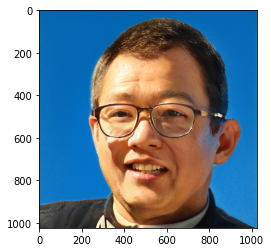

In [ ]:
test_input = torch.randn(1,512).cuda()

output, _ = generator([test_input], False)
visual(output)

In [ ]:
# for 9_409 in the paper, you should have "style_space[index[9]][:, 409]"
# the value to shift is hand-craft

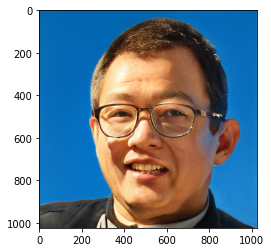

In [ ]:
# eye
style_space, latent, noise = encoder(generator, test_input)
style_space[index[9]][:, 409] += 10
image = decoder(generator, style_space, latent, noise)
visual(image)

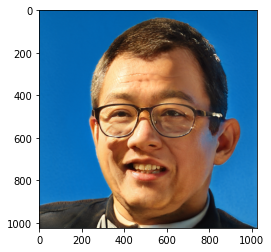

In [ ]:
# hair
style_space, latent, noise = encoder(generator, test_input)
style_space[index[12]][:, 330] -= 50
image = decoder(generator, style_space, latent, noise)
visual(image)

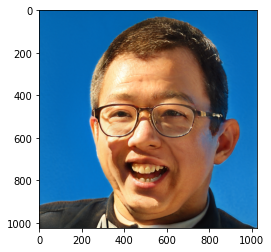

In [ ]:
# mouth
style_space, latent, noise = encoder(generator, test_input)
style_space[index[6]][:, 259] -= 20
image = decoder(generator, style_space, latent, noise)
visual(image)

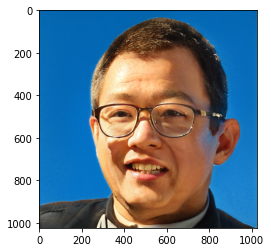

In [ ]:
# lip
style_space, latent, noise = encoder(generator, test_input)
style_space[index[15]][:, 45] -= 3
image = decoder(generator, style_space, latent, noise)
visual(image)

# InterfaceGAN

## 创建模型

In [ ]:
#@title { display-mode: "form"}
latent_space_type = "W" #@param ['Z', 'W', 'S(style&torgb)', 'S(style)', 'S(torgb)']
save_result_images = True #@param {type:"boolean"}
file_path = "/content/drive/MyDrive/Images/BoundaryExpRst" #@param {type:"string"}
boundary_path = "/content/drive/MyDrive/Images/w_transfer_from_z_08_09/codes/boundary_0.45.npy" #@param {type:"string"}

generator = build_generator()

boundaries = np.load(boundary_path)

import datetime
time_str = datetime.datetime.now().strftime('%m_%d_%H_%M')

# 特殊处理一下S隐空间的标识符
if latent_space_type.startswith("S"):
  if latent_space_type == "S(style&torgb)":
    time_str = time_str + "_st"
    space_type = "S_ST"
  elif latent_space_type == "S(style)":
    time_str = time_str + "_s"
    space_type = "S_S"
  elif latent_space_type == "S(torgb)":
    time_str = time_str + "_t"
    space_type = "S_T"
else:
  time_str = time_str + "_" + latent_space_type
  space_type = latent_space_type

root_dir = f"{file_path}/{time_str}"
if save_result_images:
  os.mkdir(root_dir)

## 生成latent code

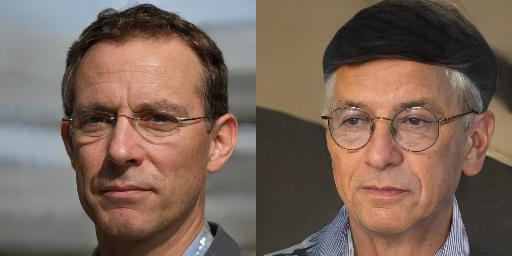

In [ ]:
#@title { display-mode: "form", run: "auto" }

num_samples = 2 #@param {type:"slider", min:1, max:8, step:1}
noise_seed = 402 #@param {type:"slider", min:0, max:1000, step:1}
is_vertical = False #@param {type:"boolean"}

latent_codes = sample_codes(generator, num_samples, space_type, noise_seed)

images = easy_synthesis(latent_codes, generator, space_type)
if is_vertical is False:
  fused_images = imshow(images, col=num_samples)
else:
  fused_images = imshow(images, col=1)

if save_result_images:
  save_img(fused_images, f"{root_dir}/origin_seed_{noise_seed}.png")

## 编辑属性

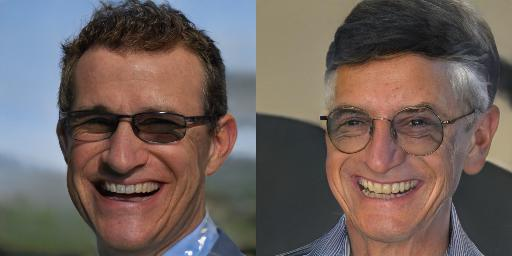

In [ ]:
#@title { display-mode: "form", run: "auto" }

smile = 10 #@param {type:"slider", min:-30, max:50, step:0.5}

new_codes = get_new_codes(latent_codes, boundaries, smile, space_type)

new_images = easy_synthesis(new_codes, generator, space_type)

if is_vertical is False:
  new_fused_images = imshow(new_images, col=num_samples)
else:
  new_fused_images = imshow(new_images, col=1)

if save_result_images:
  save_img(new_fused_images, f"{root_dir}/edited_eval_{smile}.png")

# StyleIntervention

## 创建模型

In [16]:
#@title { display-mode: "form"}
latent_space_type = "S(style&torgb)" #@param ['S(style&torgb)', 'S(style)', 'S(torgb)']
intervention_space_type = "W" #@param ["Z", "W"]
save_result_images = True #@param {type:"boolean"}
file_path = "/content/drive/MyDrive/Images/BoundaryExpRst" #@param {type:"string"}
model_stat_path = "/content/drive/MyDrive/Images/s_transfer_from_z_08_09/TrainRst/Best/weight_1e3_loss_w/layer_8.pkl"#@param {type:"string"}
boundary_s_path = "/content/drive/MyDrive/Images/s_transfer_from_z_08_09/codes/boundary_0.45_st.npy" #@param {type:"string"}
boundary_inter_path = "/content/drive/MyDrive/Images/w_transfer_from_z_08_09/codes/boundary_0.45.npy" #@param {type:"string"}

import datetime
import torch

time_str = datetime.datetime.now().strftime('%m_%d_%H_%M')

# 特殊处理一下S隐空间的标识符
if latent_space_type.startswith("S"):
  if latent_space_type == "S(style&torgb)":
    time_str = time_str + "_st"
    space_type = "S_ST"
  elif latent_space_type == "S(style)":
    time_str = time_str + "_s"
    space_type = "S_S"
  elif latent_space_type == "S(torgb)":
    time_str = time_str + "_t"
    space_type = "S_T"
else:
  time_str = time_str + "_" + latent_space_type
  space_type = latent_space_type

generator = build_generator()
boundary_inter = np.load(boundary_inter_path)
boundary_s = np.load(boundary_s_path)

#计算delta_sn
delta_sn = boundary_s

if space_type == "S_ST" and delta_sn.shape[1]!=9088:
  raise SystemError("请选择正确的ST法向量")
elif space_type == "S_S" and delta_sn.shape[1]!=6048:
  raise SystemError("请选择正确的S法向量")
if space_type == "S_T" and delta_sn.shape[1]!=3040:
  raise SystemError("请选择正确的T法向量")

# 加载Intervention Model
intervention = StyleIntervention(space_type)
stat_dict = torch.load(model_stat_path)
intervention.load_state_dict(stat_dict)
intervention.eval()
intervention.cpu()

if save_result_images:
  root_dir = f"{file_path}/intervention_{time_str}"
  if save_result_images:
    os.mkdir(root_dir)

In [ ]:
delta_sn.shape

(1, 9088)

## 生成latent code

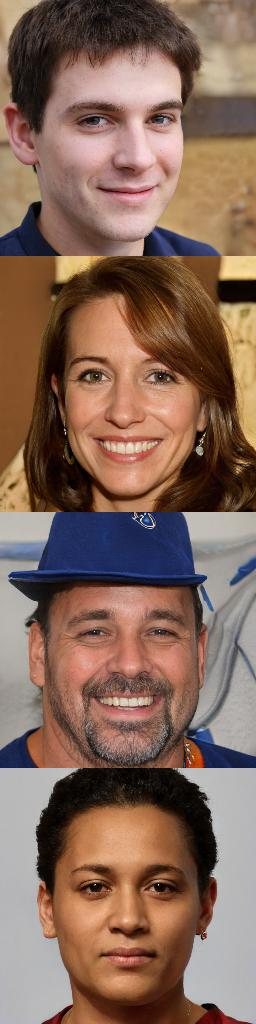

In [18]:
#@title { display-mode: "form", run: "auto" }

num_samples = 4 #@param {type:"slider", min:1, max:8, step:1}
noise_seed = 900 #@param {type:"slider", min:0, max:1000, step:1}
# 图片是否为竖直方向
is_vertical = True #@param {type:"boolean"}

# 生成交互空间code
inter_codes = sample_codes(generator, num_samples, intervention_space_type, noise_seed)
s_codes = transfer_latent_space(generator, inter_codes, intervention_space_type, "S")

# 方法一 计算出delta_sz后进行固定，后面利用这个delta_sz计算的delta_s
# 进行codes的改变
# 计算delta_sz
# new_z_codes = get_new_codes(z_codes, boundary_z, 1)
# new_s_codes = transfer_latent_space(generator, new_z_codes, "Z", "S")

# delta_sz = [[],[]]
# for i in range(2):
#   for j in range(len(new_s_codes[i])):
#     delta_sz[i].append(new_s_codes[i][j]-s_codes[i][j])

# if space_type == "S_ST":
#   delta_sz = s_space_code_process.cat_style_trgb(delta_sz[0], delta_sz[1])
# elif space_type == "S_S":
#   delta_sz = s_space_code_process.cat_codes(delta_sz[0])
# elif space_type == "S_T":
#   delta_sz = s_space_code_process.cat_codes(delta_sz[1])

# # 计算delta_s
# with torch.no_grad():
#   delta_s = intervention(delta_sz, delta_sn)
#   delta_s = delta_s.numpy()

images = easy_synthesis(s_codes, generator, space_type)
if is_vertical is False:
  fused_images = imshow(images, col=num_samples)
else:
  fused_images = imshow(images, col=1)

if save_result_images:
  save_img(fused_images, f"{root_dir}/origin_seed_{noise_seed}.png")

## 编辑属性

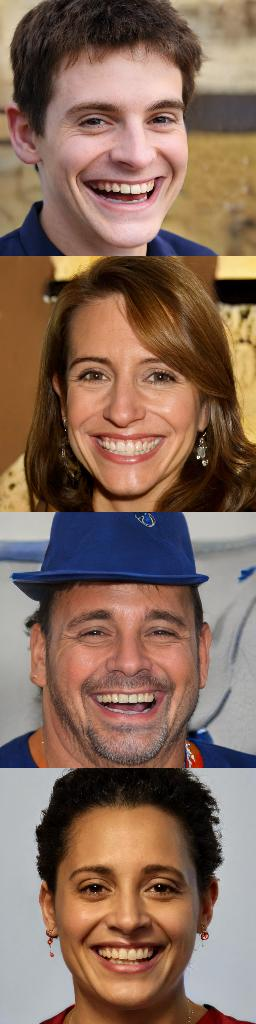

In [27]:
from math import e
#@title { display-mode: "form", run: "auto" }

smile = 9 #@param {type:"slider", min:-30, max:40, step:0.5}

# 方法二 改变smile后，利用新的smile计算delta_sz
# 计算delta_sz
new_inter_codes = get_new_codes(inter_codes, boundary_inter, 1, intervention_space_type)
new_s_codes = transfer_latent_space(generator, new_inter_codes, intervention_space_type, "S")

delta_sz = [[],[]]
for i in range(2):
  for j in range(len(new_s_codes[i])):
    delta_sz[i].append(new_s_codes[i][j]-s_codes[i][j])

if space_type == "S_ST":
  delta_sz = s_space_code_process.cat_style_trgb(delta_sz[0], delta_sz[1])
elif space_type == "S_S":
  delta_sz = s_space_code_process.cat_codes(delta_sz[0])
elif space_type == "S_T":
  delta_sz = s_space_code_process.cat_codes(delta_sz[1])

# 计算delta_s
with torch.no_grad():
  delta_s = intervention(delta_sz, delta_sn)
  delta_s = delta_s.numpy()

new_codes = get_new_codes(s_codes, delta_s, smile, space_type)

new_images = easy_synthesis(new_codes, generator, space_type)
if is_vertical is False:
  new_fused_images = imshow(new_images, col=num_samples)
else:
  new_fused_images = imshow(new_images, col=1)

if save_result_images:
  save_img(new_fused_images, f"{root_dir}/edited_eval_{smile}.png")

In [ ]:
print("delta_sz/delta_sn", np.mean(delta_sz/delta_sn, axis=1))
print("delta_s/delta_sn", np.mean(delta_s/delta_sn, axis=1))

delta_sz/delta_sn [ 4.88751    7.490862  -1.7192345  6.358739 ]
delta_s/delta_sn [ 2.923859   2.1230478 -0.2476675  2.0886238]


## 拼接图片

In [28]:
def show_full_image(image):
  # 输入为[h，w，c]大小的numpy数组
  data = io.BytesIO()
  PIL.Image.fromarray(image).save(data, 'jpeg')
  im_data = data.getvalue()
  disp = IPython.display.display(IPython.display.Image(im_data))

def concatenate_images(images, axis=0):
  """Shows images in one figure."""
  num, height, width, channels = images.shape

  if axis == 0:
    fused_image = np.zeros((height * num, width, channels), dtype=np.uint8)

    for idx, image in enumerate(images):
      y = idx * height
      fused_image[y:y + height, 0:width] = image
  elif axis == 1:
    fused_image = np.zeros((height, width*num, channels), dtype=np.uint8)
    for idx, image in enumerate(images):
      x = idx * width
      fused_image[0:height, x:x+width] = image

  fused_image = np.asarray(fused_image, dtype=np.uint8)
  return fused_image

### 拼接同一隐空间不同eval的图片

In [ ]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np
import cv2

root_dir = "/content/drive/MyDrive/Images/BoundaryExpRst/interface_st_best_exp"
edit_prefix = "edited_eval"


# /content/drive/MyDrive/Images/BoundaryExpRst/interface_z_best_exp
# edit_val = [-5, -3, -1, 0, 1, 3, 5]

# /content/drive/MyDrive/Images/BoundaryExpRst/interface_w_best_exp
# edit_val = [-10, -5, -3, 0, 3, 5, 10]

# /content/drive/MyDrive/Images/BoundaryExpRst/interface_st_best_exp
edit_val = [-20, -10, -5, 0, 5, 10, 20]


images = np.empty(shape=[0, 256, 1024, 3])
for i in edit_val:
  num_str = str(i)
  img_path = f"{root_dir}/{edit_prefix}_{num_str}.png"
  img = mpimg.imread(img_path)
  img = (img * 255).astype(np.uint8)
  images = np.concatenate((images, img[None, ...]), axis=0)
print(images.shape)
fused_images = concatenate_images(images)

# 添加空白区域用于添加文本
height, width, channels = fused_images.shape
white_area = (np.ones(shape=[height, 200, channels])*255).astype(np.uint8)
new_fused_images = np.concatenate((white_area, fused_images), axis=1)

# 添加文本
# 使用默认字体
font=cv2.FONT_HERSHEY_SIMPLEX
# 添加文字
# (30,128)是初始的位置，水平轴为x，数值轴为y
# 1 表示字体大小，
# (0,0,0)表示颜色，2表示粗细
for i in range(len(edit_val)):
  cv2.putText(new_fused_images, f'eval={str(edit_val[i])}', (30,128+i*256), font, 1, (0,0,0), 2)

show_full_image(new_fused_images)

cv2.imwrite(f"{root_dir}/fused.png", new_fused_images[...,::-1])

### 拼接不同空间的图片

(5, 1024, 256, 3)


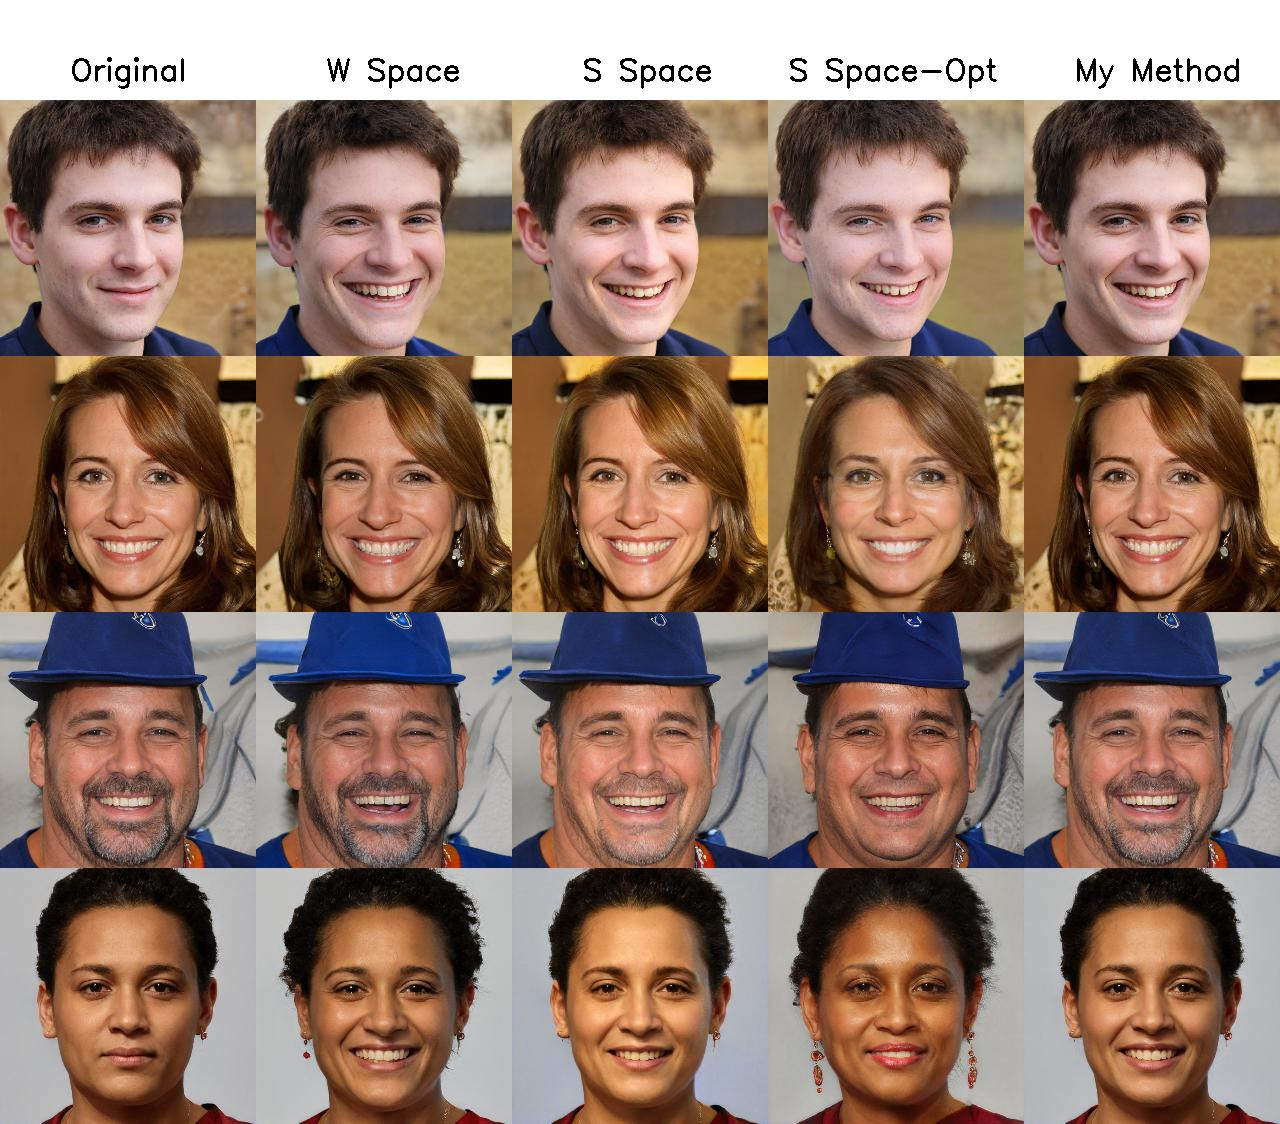

In [37]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np
import cv2

z_dir = "/content/drive/MyDrive/Images/BoundaryExpRst/w_vertical"
w_dir = "/content/drive/MyDrive/Images/BoundaryExpRst/st_vertical"
s_dir = "/content/drive/MyDrive/Images/BoundaryExpRst/intervention_st_vertical"
inter_s_dir = "/content/drive/MyDrive/Images/BoundaryExpRst/opt_intervention_st"
origin_pic_path = "/content/drive/MyDrive/Images/BoundaryExpRst/opt_intervention_st/origin_seed_900.png"
edit_prefix = "edited_eval"


# z
z_edit_val = [5]

# w
w_edit_val = [30]

# s
s_edit_val = [20]

# inter
inter_s_edit_val = [4]


# 读取原本的图片
images = mpimg.imread(origin_pic_path)
images = (images * 255).astype(np.uint8)
images = images[None, ...]

for i in z_edit_val:
  num_str = str(i)
  img_path = f"{z_dir}/{edit_prefix}_{num_str}.png"
  img = mpimg.imread(img_path)
  img = (img * 255).astype(np.uint8)
  images = np.concatenate((images, img[None, ...]), axis=0)

for i in w_edit_val:
  num_str = str(i)
  img_path = f"{w_dir}/{edit_prefix}_{num_str}.png"
  img = mpimg.imread(img_path)
  img = (img * 255).astype(np.uint8)
  images = np.concatenate((images, img[None, ...]), axis=0)

for i in s_edit_val:
  num_str = str(i)
  img_path = f"{s_dir}/{edit_prefix}_{num_str}.png"
  img = mpimg.imread(img_path)
  img = (img * 255).astype(np.uint8)
  images = np.concatenate((images, img[None, ...]), axis=0)

for i in inter_s_edit_val:
  num_str = str(i)
  img_path = f"{inter_s_dir}/{edit_prefix}_{num_str}.png"
  img = mpimg.imread(img_path)
  img = (img * 255).astype(np.uint8)
  images = np.concatenate((images, img[None, ...]), axis=0)

print(images.shape)
fused_images = concatenate_images(images, axis=1)

# 添加空白区域用于添加文本
height, width, channels = fused_images.shape
white_area = (np.ones(shape=[100, width, channels])*255).astype(np.uint8)
new_fused_images = np.concatenate((white_area, fused_images), axis=0)

# 添加文本
# 使用默认字体
font=cv2.FONT_HERSHEY_SIMPLEX
# 添加文字
# (30,128)是初始的位置，水平轴为x，数值轴为y
# 1 表示字体大小，
# (0,0,0)表示颜色，2表示粗细

cv2.putText(new_fused_images, f'Original', (70+256*0,80), font, 1, (0,0,0), 2)
#cv2.putText(new_fused_images, f'eval=-20', (30+256*0,150), font, 1, (0,0,0), 2)
cv2.putText(new_fused_images, f'W Space', (70+256*1,80), font, 1, (0,0,0), 2)
#cv2.putText(new_fused_images, f'eval=-3', (30+256*1,150), font, 1, (0,0,0), 2)
cv2.putText(new_fused_images, f'S Space', (70+256*2,80), font, 1, (0,0,0), 2)
#cv2.putText(new_fused_images, f'eval=-10', (30+256*2,150), font, 1, (0,0,0), 2)
cv2.putText(new_fused_images, f'S Space-Opt', (20+256*3,80), font, 1, (0,0,0), 2)
#cv2.putText(new_fused_images, f'eval=-10', (30+256*3,150), font, 1, (0,0,0), 2)
cv2.putText(new_fused_images, f'My Method', (50+256*4,80), font, 1, (0,0,0), 2)
#cv2.putText(new_fused_images, f'eval=-10', (30+256*4,150), font, 1, (0,0,0), 2)

show_full_image(new_fused_images)

# cv2.imwrite(f"{inter_s_dir}/fused.png", new_fused_images[...,::-1])

# 拼接实验结果